In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

from matplotlib import pyplot as plt
import matplotlib

import brokenaxes
from brokenaxes import brokenaxes as brokax
from matplotlib.gridspec import GridSpec
from matplotlib.transforms import ScaledTranslation
import sklearn
import uncertainties
import os
import scipy
import torch

import string

from pathlib import Path
import matplotlib.patches as mpatches

import Utils as ut
import Models as mod
%matplotlib inline

AEs_order=["GRAE","TAE","AE","VAE","PeakVI","scVI","siVAE","PCA"]
new_colors=[ut.colors_to_use_pastel[4], ut.colors_to_use_pastel[1], ut.colors_to_use_pastel[6], ut.colors_to_use_pastel[2], 
ut.colors_to_use_pastel[3], ut.colors_to_use_pastel[0], ut.colors_to_use_bright[1], ut.colors_to_use_pastel[8]]
palette = {AEs_order[i] : new_colors[i] for i in range(len(AEs_order))} 

# Robustness

## CMs and Jobs

In [ ]:
datasets=["10XhsBrain3kMO", "10XhsBrain3kMO","Kidney", "10XhsPBMC10kMO","10XhsPBMC10kMO", "MouseBrain"]
featurespaces=["Peak","GEX","Peak", "Peak", "GEX", "Peak"]
jobs=["BrP", "BrG", "KiP", "PbP", "PbG", "MbP"]
for dataset, featurespace, job in zip(datasets, featurespaces, jobs):
    print(dataset, featurespace)
    adata=sc.read_h5ad(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_QC.h5ad")
    for d in np.linspace(0, 50, 11).astype(int):
        print(d)
        for run in range(0, 10):
				m = torch.nn.Dropout(p=d/100)
				inp = torch.tensor(adata.X.todense())
				output = m(inp)
				adata.layers[f"X_{str(d)}_{str(run)}"]=scipy.sparse.csr_matrix(output)
    adata.write(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_Dropout.h5ad", compression="gzip")

In [ ]:
datasets=["10XhsBrain3kMO", "10XhsBrain3kMO","Kidney", "10XhsPBMC10kMO","10XhsPBMC10kMO", "MouseBrain"]
featurespaces=["Peak","GEX","Peak", "Peak", "GEX", "Peak"]
jobs=["BrP", "BrG", "KiP", "PbP", "PbG", "MbP"]
for dataset, featurespace, job in zip(datasets, featurespaces, jobs):
    print(dataset, featurespace, job)
    for ae in ["GRAE","TAE","AE","VAE","PeakVI","scVI"]
        os.system(f"sbatch -p slim18 -J Dp{job}{AE} --mem=32G --nodes=1 --ntasks-per-node=1 --cpus-per-task=6 --time 7-00:00:00\
			       --output=Datasets/{dataset}/Out/{dataset}_{featurespace}_{AE}_Dropout.out Run_Exp.sh Robustness {AE} {dataset} {featurespace}")

In [ ]:
#RUN THIS IN THE ENV WHERE siVAE IS INSTALLED AND IN THE FOLDER DOWNLOEADED FROM siVAE github
datasets=["10XhsBrain3kMO", "10XhsBrain3kMO","Kidney", "10XhsPBMC10kMO","10XhsPBMC10kMO", "MouseBrain"]
featurespaces=["Peak","GEX","Peak", "Peak", "GEX", "Peak"]
jobs=["BrP", "BrG", "KiP", "PbP", "PbG", "MbP"]
for dataset, featurespace, job in zip(datasets, featurespaces, jobs):
    print(dataset, featurespace, job)
    os.system(f"sbatch -p slim18 -J Dp{job}siVAE --mem=32G --nodes=1 --ntasks-per-node=1 --cpus-per-task=6 --time 7-00:00:00\
			       --output=Datasets/{dataset}/Out/{dataset}_{featurespace}_siVAE_Dropout.out Run_Exp.sh Robustness siVAE {dataset} {featurespace}")

# Figures

## SEAGALL_Fig2

In [5]:
df=pd.read_csv("Tables/Robustness.tsv.gz", sep="\t")
df2=pd.read_csv("Tables/Robustness_siVAE.tsv.gz", sep="\t")
df=pd.concat([df, df2])
datasets=["Kidney","Human brain","Human brain", "Mouse brain", "PBMC","PBMC"]
featurespaces=["Peaks","Peaks", "GEX", "Peaks", "Peaks", "GEX"]
jobs=["BrP", "BrG", "KiP", "PbP", "PbG", "MbP"]

df["FS"]=df["FS"].replace("Peak","Peaks")
df["Dataset"]=df["Dataset"].replace("10XhsBrain3kMO","Human brain")
df["Dataset"]=df["Dataset"].replace("10XhsPBMC10kMO","PBMC")
df["Dataset"]=df["Dataset"].replace("MouseBrain","Mouse brain")
df.head()

Dataset     FS      AE  Dropout       MSE   MSE1obs   MSE1imp  \
0  Human brain  Peaks      AE        0  0.011209  0.060707  0.011349   
1  Human brain  Peaks     VAE        0  0.247601  0.300532  0.257044   
2  Human brain  Peaks     TAE        0  0.009960  0.059894  0.007615   
3  Human brain  Peaks    GRAE        0  0.006533  0.035127  0.001869   
4  Human brain  Peaks  PeakVI        0  0.256767  0.245840  0.522231   

   Spearman    NBloss  Run  
0  0.001100  0.144949    1  
1  0.000247  0.304475    1  
2  0.012973  0.132526    1  
3  0.200109  0.042375    1  
4  0.000384  0.506129    1

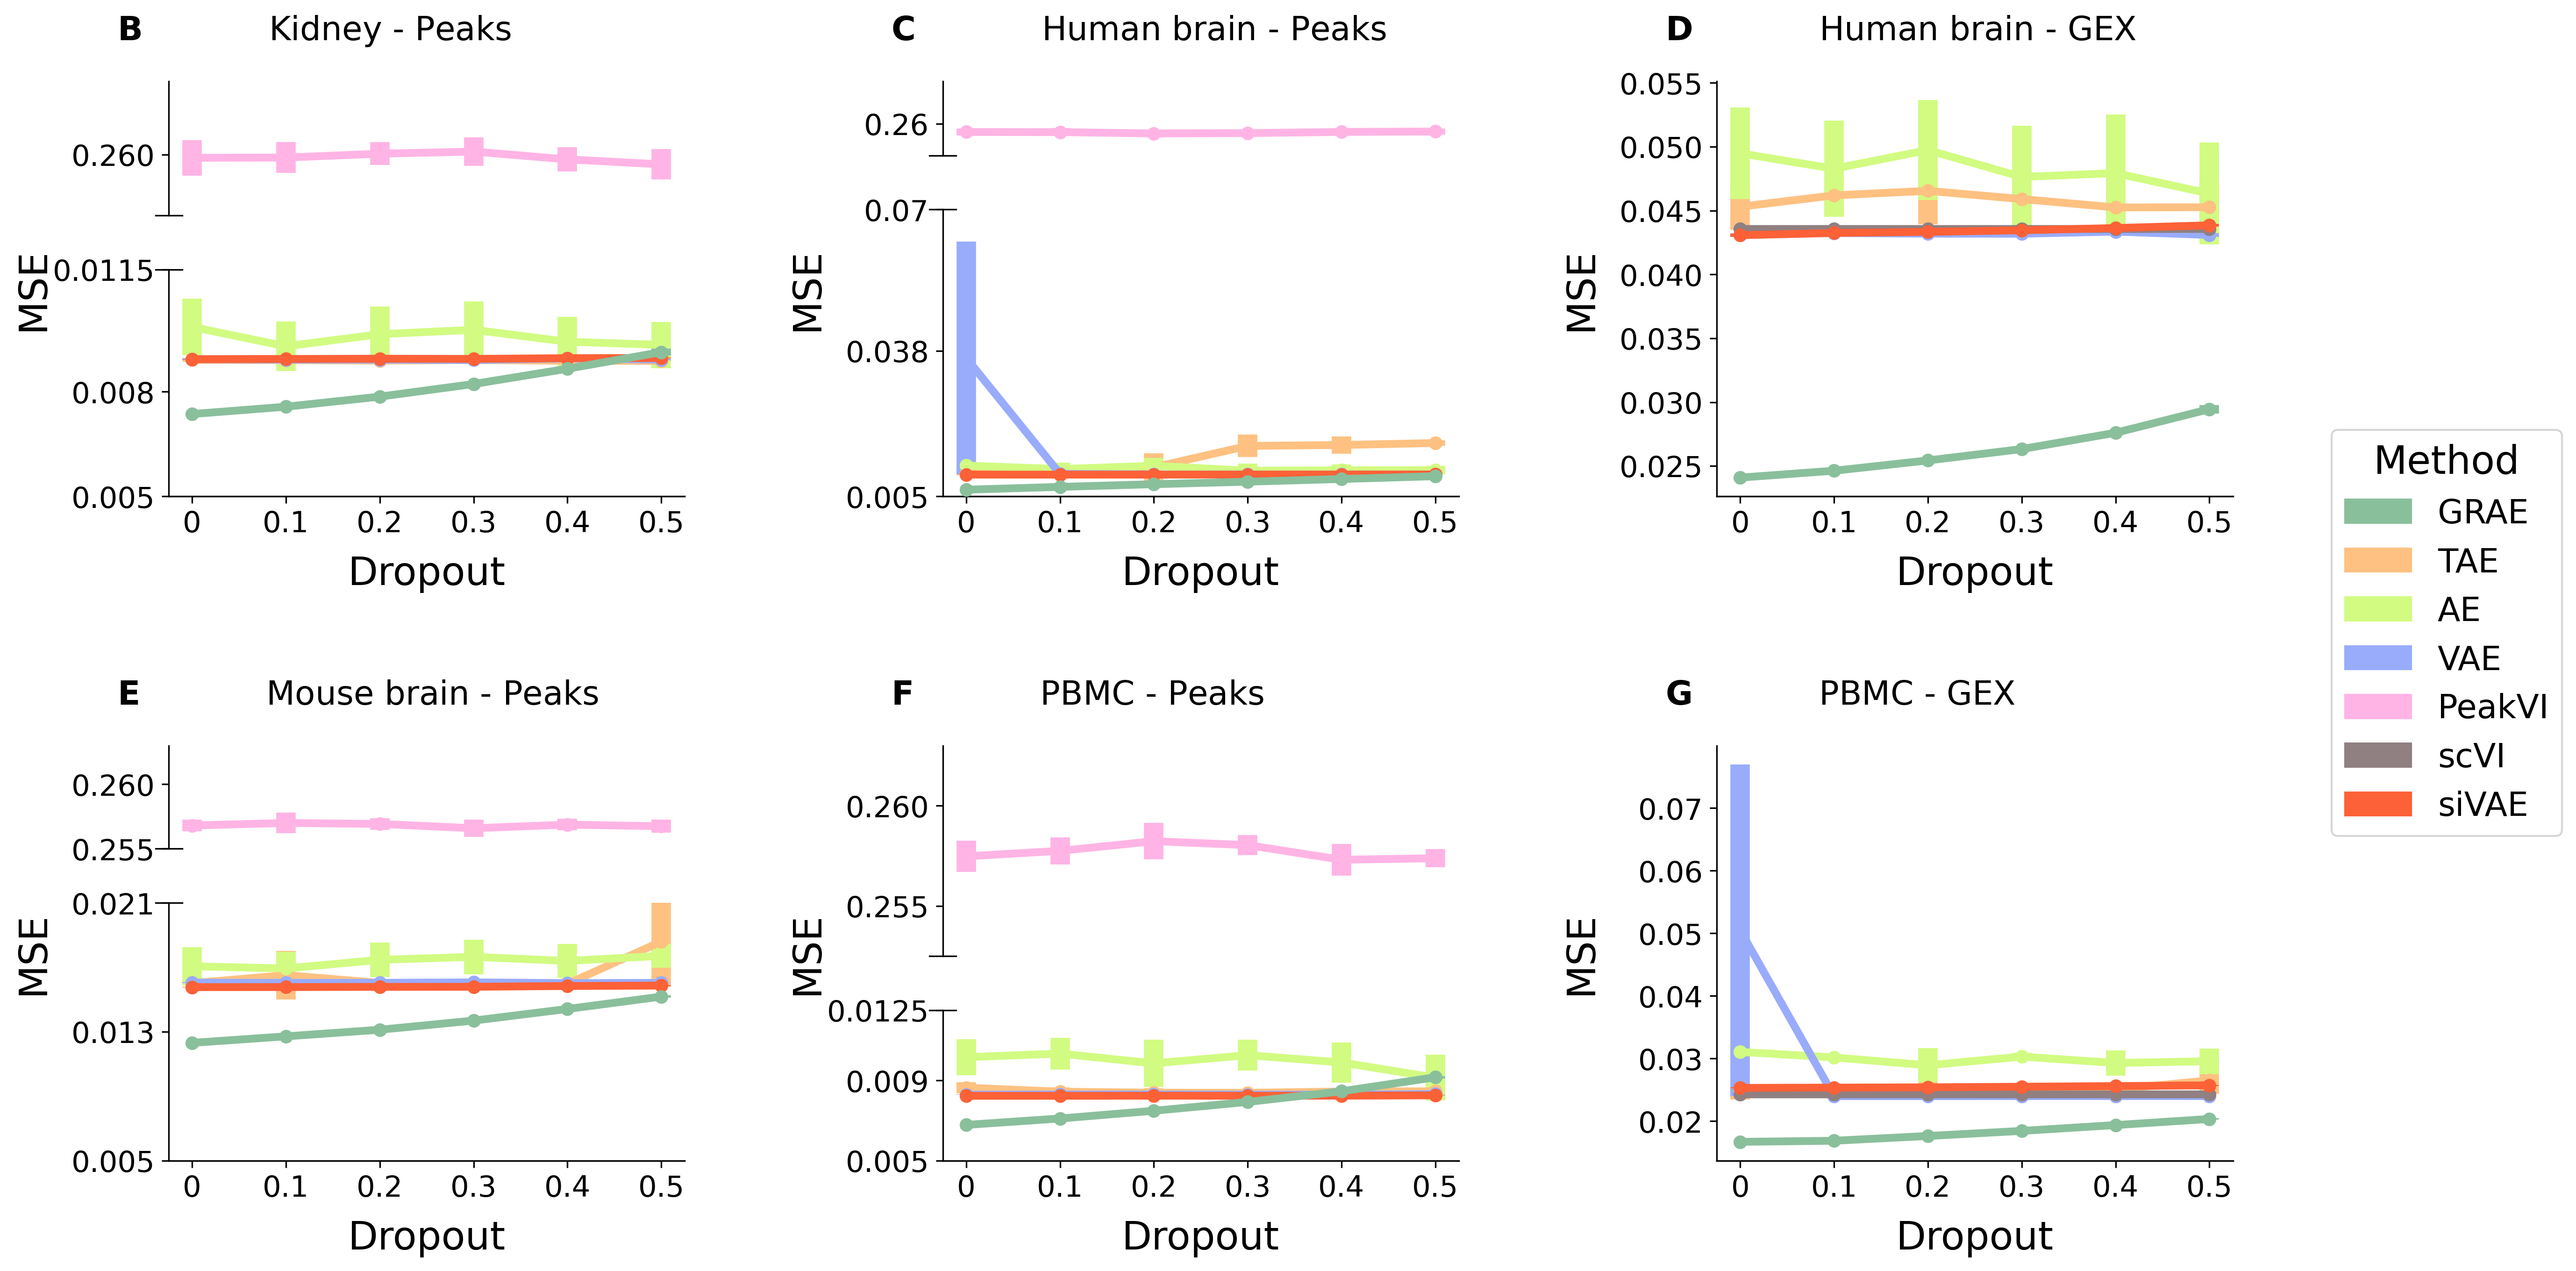

In [8]:
palette_red = {ae : palette[ae] for ae in palette.keys() if ae in set(df["AE"])}
x=np.linspace(0, 50, 6).astype(int)/100
xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5]
pad_pts=0
sps1, sps2 = GridSpec(2,1)
params = {'axes.labelsize': 20,
			'axes.titlesize': 20,
			'xtick.labelsize' : 15,
			'ytick.labelsize': 15,
			"lines.linewidth" : 4,
			"figure.dpi" : 300,
			"figure.figsize": [19, 10]}
plt.rcParams.update(params)
fig = plt.figure()

gs = GridSpec(2,3, wspace=0.5, hspace=0.6)
spss = {f"sps{i}" : sp for i, sp in enumerate(gs)}
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[0, 2])
ax6 = fig.add_subplot(gs[1, 2])
xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5]
i=0
for dataset, featurespace, job in zip(datasets, featurespaces, jobs):
    d=df[(df["Dataset"]==dataset) & (df["FS"]==featurespace)]
    if i == 0:
        maxy=0.0115
        y_breaks=((0.0022, maxy), (0.2575,0.263))
    elif i == 1:
        maxy=0.07
        y_breaks=((0.0022, maxy), (0.2525,0.27))
    elif  i == 3:
        maxy=0.021
        y_breaks=((0.001, maxy), (0.255,0.263))
    elif i == 4:
        maxy=0.0125
        y_breaks=((0.005, maxy), (0.2525,0.263))
    else:
        y_breaks=None
    bax = brokax(ylims=y_breaks, hspace=0.3, subplot_spec=spss[f"sps{i}"], tilt=0, d=0.005)
    for AE in AEs_order:
        if AE in list(set(d["AE"])):
                zorder=10 if AE=="GRAE" else 1
                d_ae=d[d["AE"]==AE].copy()
                y=d_ae.groupby("Dropout")["MSE"].mean()
                if AE == "VAE":
                    yerr=d_ae.groupby("Dropout")["MSE"].sem()
                else:
                    yerr=3*d_ae.groupby("Dropout")["MSE"].sem()
                bax.errorbar(x=x, y=y, yerr=yerr, ecolor=palette_red[AE], elinewidth=10, marker="o", c=palette_red[AE], zorder=zorder)  
    if "PeakVI" in set(d["AE"]):		
        bax.axs[1].set_xticks(xticks, xticks)
        bax.axs[1].set_ylim([0.005, maxy])
        bax.axs[1].set_yticks([0.005, np.around((0.005+maxy)/2, decimals=3),maxy], [0.005, np.around((0.005+maxy)/2, decimals=3),maxy])
    else:
        bax.axs[0].set_xticks(xticks, xticks)	

    bax.spines['top'][0].set_visible(False)
    bax.spines['right'][0].set_visible(False)
    try:
        bax.axs[0].set_xlabel('', rotation=0, labelpad=10)
        bax.axs[0].set_ylabel('', rotation=90, labelpad=10)
    except:
        bax.set_xlabel('', rotation=0, labelpad=10)
        bax.set_ylabel('', rotation=90, labelpad=10)
    letter=string.ascii_uppercase[i+1]
    bax.set_title(rf'$\mathbf{{{letter}}}$		{dataset} - {featurespace}', loc='left', size=17, pad=pad_pts, y=1.1, x=-0.1)
    i+=1
    
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.spines[			       'top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([], [])
    ax.set_xlabel('Dropout', rotation=0, labelpad=30)
    ax.set_ylabel('MSE', rotation=90, labelpad=60)
handles=[]
for key in AEs_order:
    if key in set(df["AE"]):
        handles.append(mpatches.Patch(color=palette_red[key], label=key))
ax5.legend(bbox_to_anchor=(1.67, 0.2), title="Method", fontsize=17, title_fontsize=20, handles=handles)

plt.savefig(f"Figures/SEAGALL_Fig2.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

## SEAGALL_Fig3

In [9]:
df=pd.read_csv("Tables/Heteorgeneity.tsv.gz", sep="\t", index_col=0)
df2=pd.read_csv("Tables/Heteorgeneity_siVAE.tsv.gz", sep="\t", index_col=0)
df=pd.concat([df, df2])
df=df[df["Dropout"]==0.0]
df["Heteorgeneity"]=np.array(df["AbsoluteHetero"]/(df["NN"]*df["N_CT"]))
df["Homogeneity"]=1-df["Heteorgeneity"]
df["Method"]=df["Method"].str.replace("_kNN","")
print(df.shape)
df["FS"]=df["FS"].replace("Peak","Peaks")
df["Dataset"]=df["Dataset"].replace("10XhsBrain3kMO","Human brain")
df["Dataset"]=df["Dataset"].replace("10XhsPBMC10kMO","PBMC")
df["Dataset"]=df["Dataset"].replace("MouseBrain","Mouse brain")
df["Dataset"]=df["Dataset"].replace("Kidney","Kidney")
datasets=["Kidney","Human brain","Human brain", "Mouse brain", "PBMC","PBMC"]
featurespaces=["Peaks","Peaks", "GEX", "Peaks", "Peaks", "GEX"]
jobs=["BrP", "BrG", "KiP", "PbP", "PbG", "MbP"]
df.head()

(1465945, 10)


Dataset     FS Method  AbsoluteHetero  NN  N_CT  Dropout  Run  \
0  Human brain  Peaks     AE               8  18     8      0.0  1.0   
1  Human brain  Peaks     AE               7  27     8      0.0  1.0   
2  Human brain  Peaks     AE               7  28     8      0.0  1.0   
3  Human brain  Peaks     AE               8  27     8      0.0  1.0   
4  Human brain  Peaks     AE               3  15     8      0.0  1.0   

   Heteorgeneity  Homogeneity  
0       0.055556     0.944444  
1       0.032407     0.967593  
2       0.031250     0.968750  
3       0.037037     0.962963  
4       0.025000     0.975000

In [ ]:
col_order=['Kidney+Peaks', 'Human brain+Peaks', 'Human brain+GEX', 'Mouse brain+Peaks', 'PBMC+Peaks','PBMC+GEX']
order=[m for m in AEs_order if m in set(df["Method"])]
d=pd.DataFrame()
metric="Homogeneity"
for dataset, featurespace, job in zip(datasets, featurespaces, jobs):
    print(dataset, featurespace)
    t=df[(df["Dataset"]==dataset) & (df["FS"]==featurespace)]
    aes=t[[metric,"Method"]].groupby("Method")[metric].mean().index
    mean=np.array(t[[metric,"Method"]].dropna().groupby("Method")[metric].mean())
    sem=np.array(3*t[[metric,"Method"]].dropna().groupby("Method")[metric].sem())
    for ae, m, s in zip(aes, mean, sem):
        d=pd.concat([d, pd.DataFrame([f"{dataset}+{featurespace}", ae, str(uncertainties.ufloat(m, s))], index=["Ds&Fs", "DR method", "Mean +- 3*SEM"]).T], axis=0)
defd=d.pivot(index="DR method", columns="Ds&Fs", values="Mean +- 3*SEM")[col_order].loc[order]
for col in defd.columns:
    defd[col]=defd[col].str.replace("+/-",u"\u00B1")
defd.to_csv("Tables/SuppTable3.tsv", sep="\t", columns=None)
defd

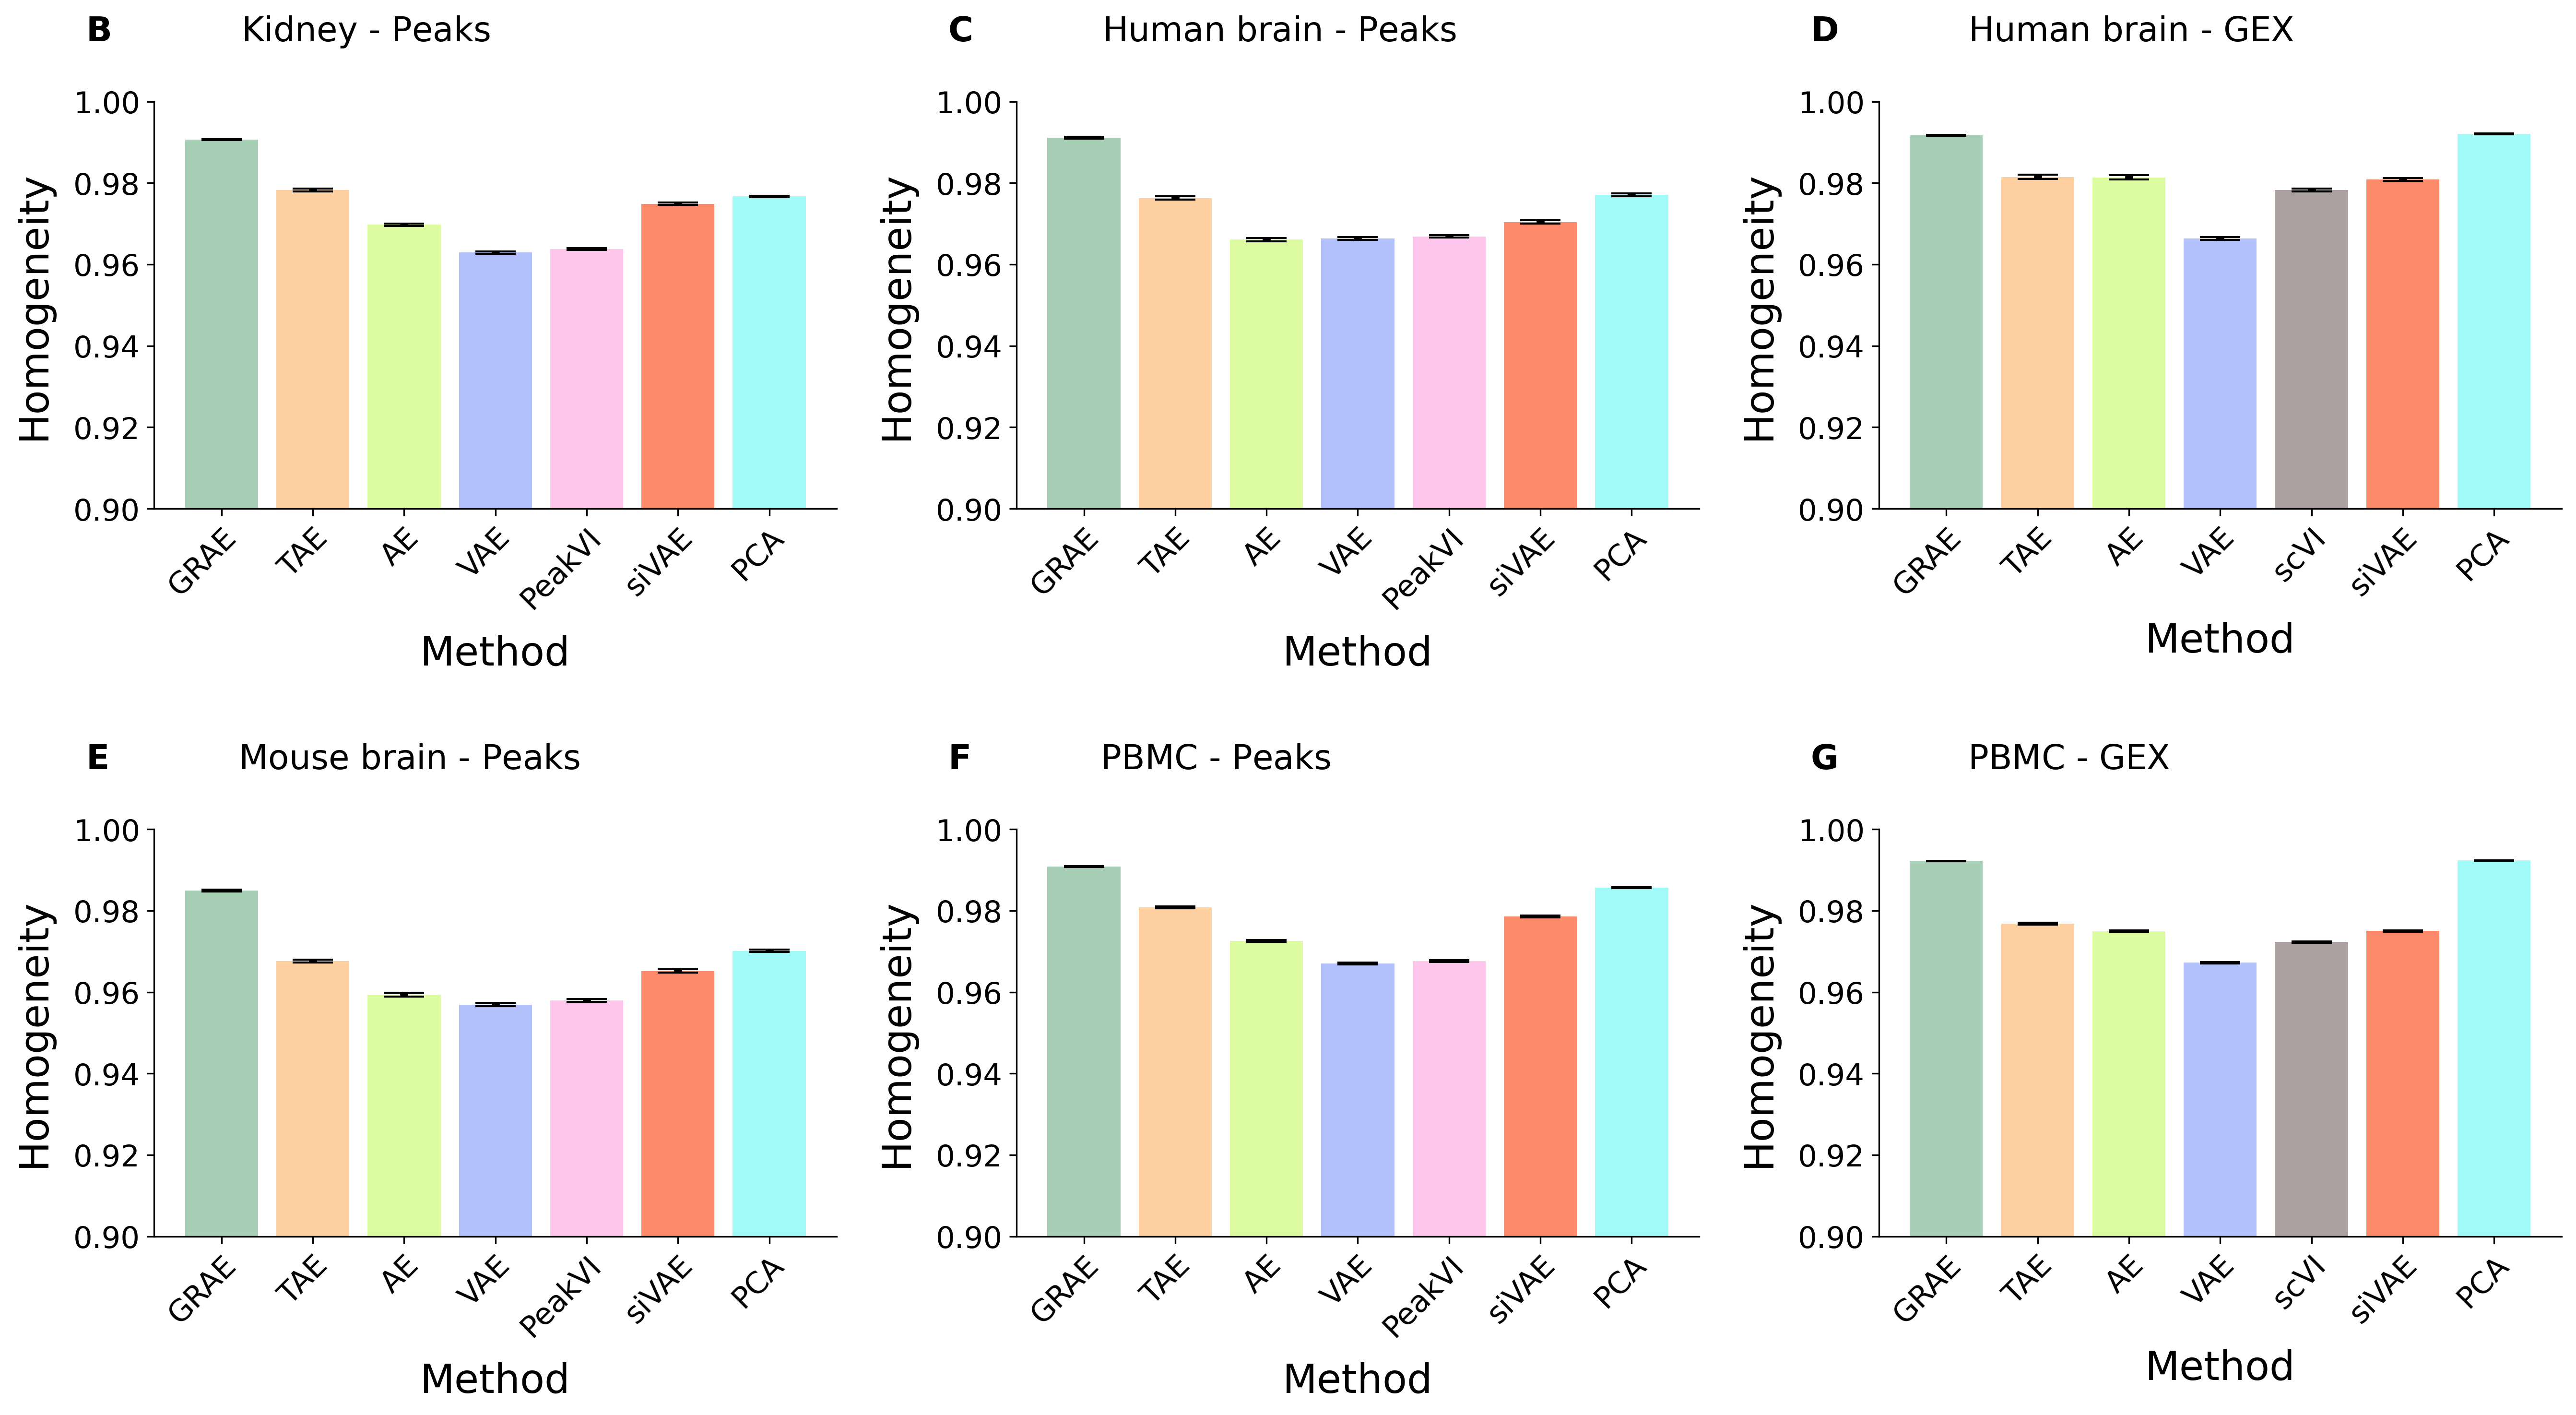

In [10]:
params = {'axes.labelsize': 20,
			'axes.titlesize': 20,
			'xtick.labelsize' : 15,
			'ytick.labelsize': 15,
			"lines.linewidth" : 4,
			"figure.dpi" : 300,
			"figure.figsize": [18, 10]}
plt.rcParams.update(params)
pad_pts=10
fig, axs = plt.subplots(2,3)
axs=axs.flatten()
i=0
for dataset, featurespace, job in zip(datasets, featurespaces, jobs):
    d=df[(df["Dataset"]==dataset) & (df["FS"]==featurespace)]  
    order=[ae for ae in AEs_order if ae in set(d["Method"])]
    colors=[palette[ae] for ae in order]
    means=np.array(d.groupby("Method")["Homogeneity"].mean().loc[order])
    sems=5*np.array(d.groupby("Method")["Homogeneity"].sem().loc[order])
    axs[i].bar(x=order, height=means, yerr=sems, color=colors, capsize=10, ecolor="black", linewidth=5, alpha=0.75, width=0.8)
    axs[i].set_ylim([0.9, 1])
    letter=string.ascii_uppercase[i+1]
    axs[i].set_title(rf'$\mathbf{{{letter}}}$		{dataset} - {featurespace}', loc='left', size=17, pad=pad_pts, y=1.1, x=-0.1)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)    
    axs[i].set_xlabel('Method', rotation=0, labelpad=10)
    axs[i].set_ylabel('Homogeneity', rotation=90, labelpad=10)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    i+=1    

fig.tight_layout(h_pad=3, w_pad=2)
plt.savefig("Figures/SEAGALL_Fig3.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

## SEAGALL_SuppFig3

In [11]:
df=pd.read_csv("Tables/Robustness.tsv.gz", sep="\t")
df2=pd.read_csv("Tables/Robustness_siVAE.tsv.gz", sep="\t")
df=pd.concat([df, df2])
datasets=["Kidney","Human brain","Human brain", "Mouse brain", "PBMC","PBMC"]
featurespaces=["Peaks","Peaks", "GEX", "Peaks", "Peaks", "GEX"]
jobs=["BrP", "BrG", "KiP", "PbP", "PbG", "MbP"]

df["FS"]=df["FS"].replace("Peak","Peaks")
df["Dataset"]=df["Dataset"].replace("10XhsBrain3kMO","Human brain")
df["Dataset"]=df["Dataset"].replace("10XhsPBMC10kMO","PBMC")
df["Dataset"]=df["Dataset"].replace("MouseBrain","Mouse brain")
df["AE"]=df["AE"].str.replace("TopoAE","TAE")
df.head()

Dataset     FS      AE  Dropout       MSE   MSE1obs   MSE1imp  \
0  Human brain  Peaks      AE        0  0.011209  0.060707  0.011349   
1  Human brain  Peaks     VAE        0  0.247601  0.300532  0.257044   
2  Human brain  Peaks     TAE        0  0.009960  0.059894  0.007615   
3  Human brain  Peaks    GRAE        0  0.006533  0.035127  0.001869   
4  Human brain  Peaks  PeakVI        0  0.256767  0.245840  0.522231   

   Spearman    NBloss  Run  
0  0.001100  0.144949    1  
1  0.000247  0.304475    1  
2  0.012973  0.132526    1  
3  0.200109  0.042375    1  
4  0.000384  0.506129    1

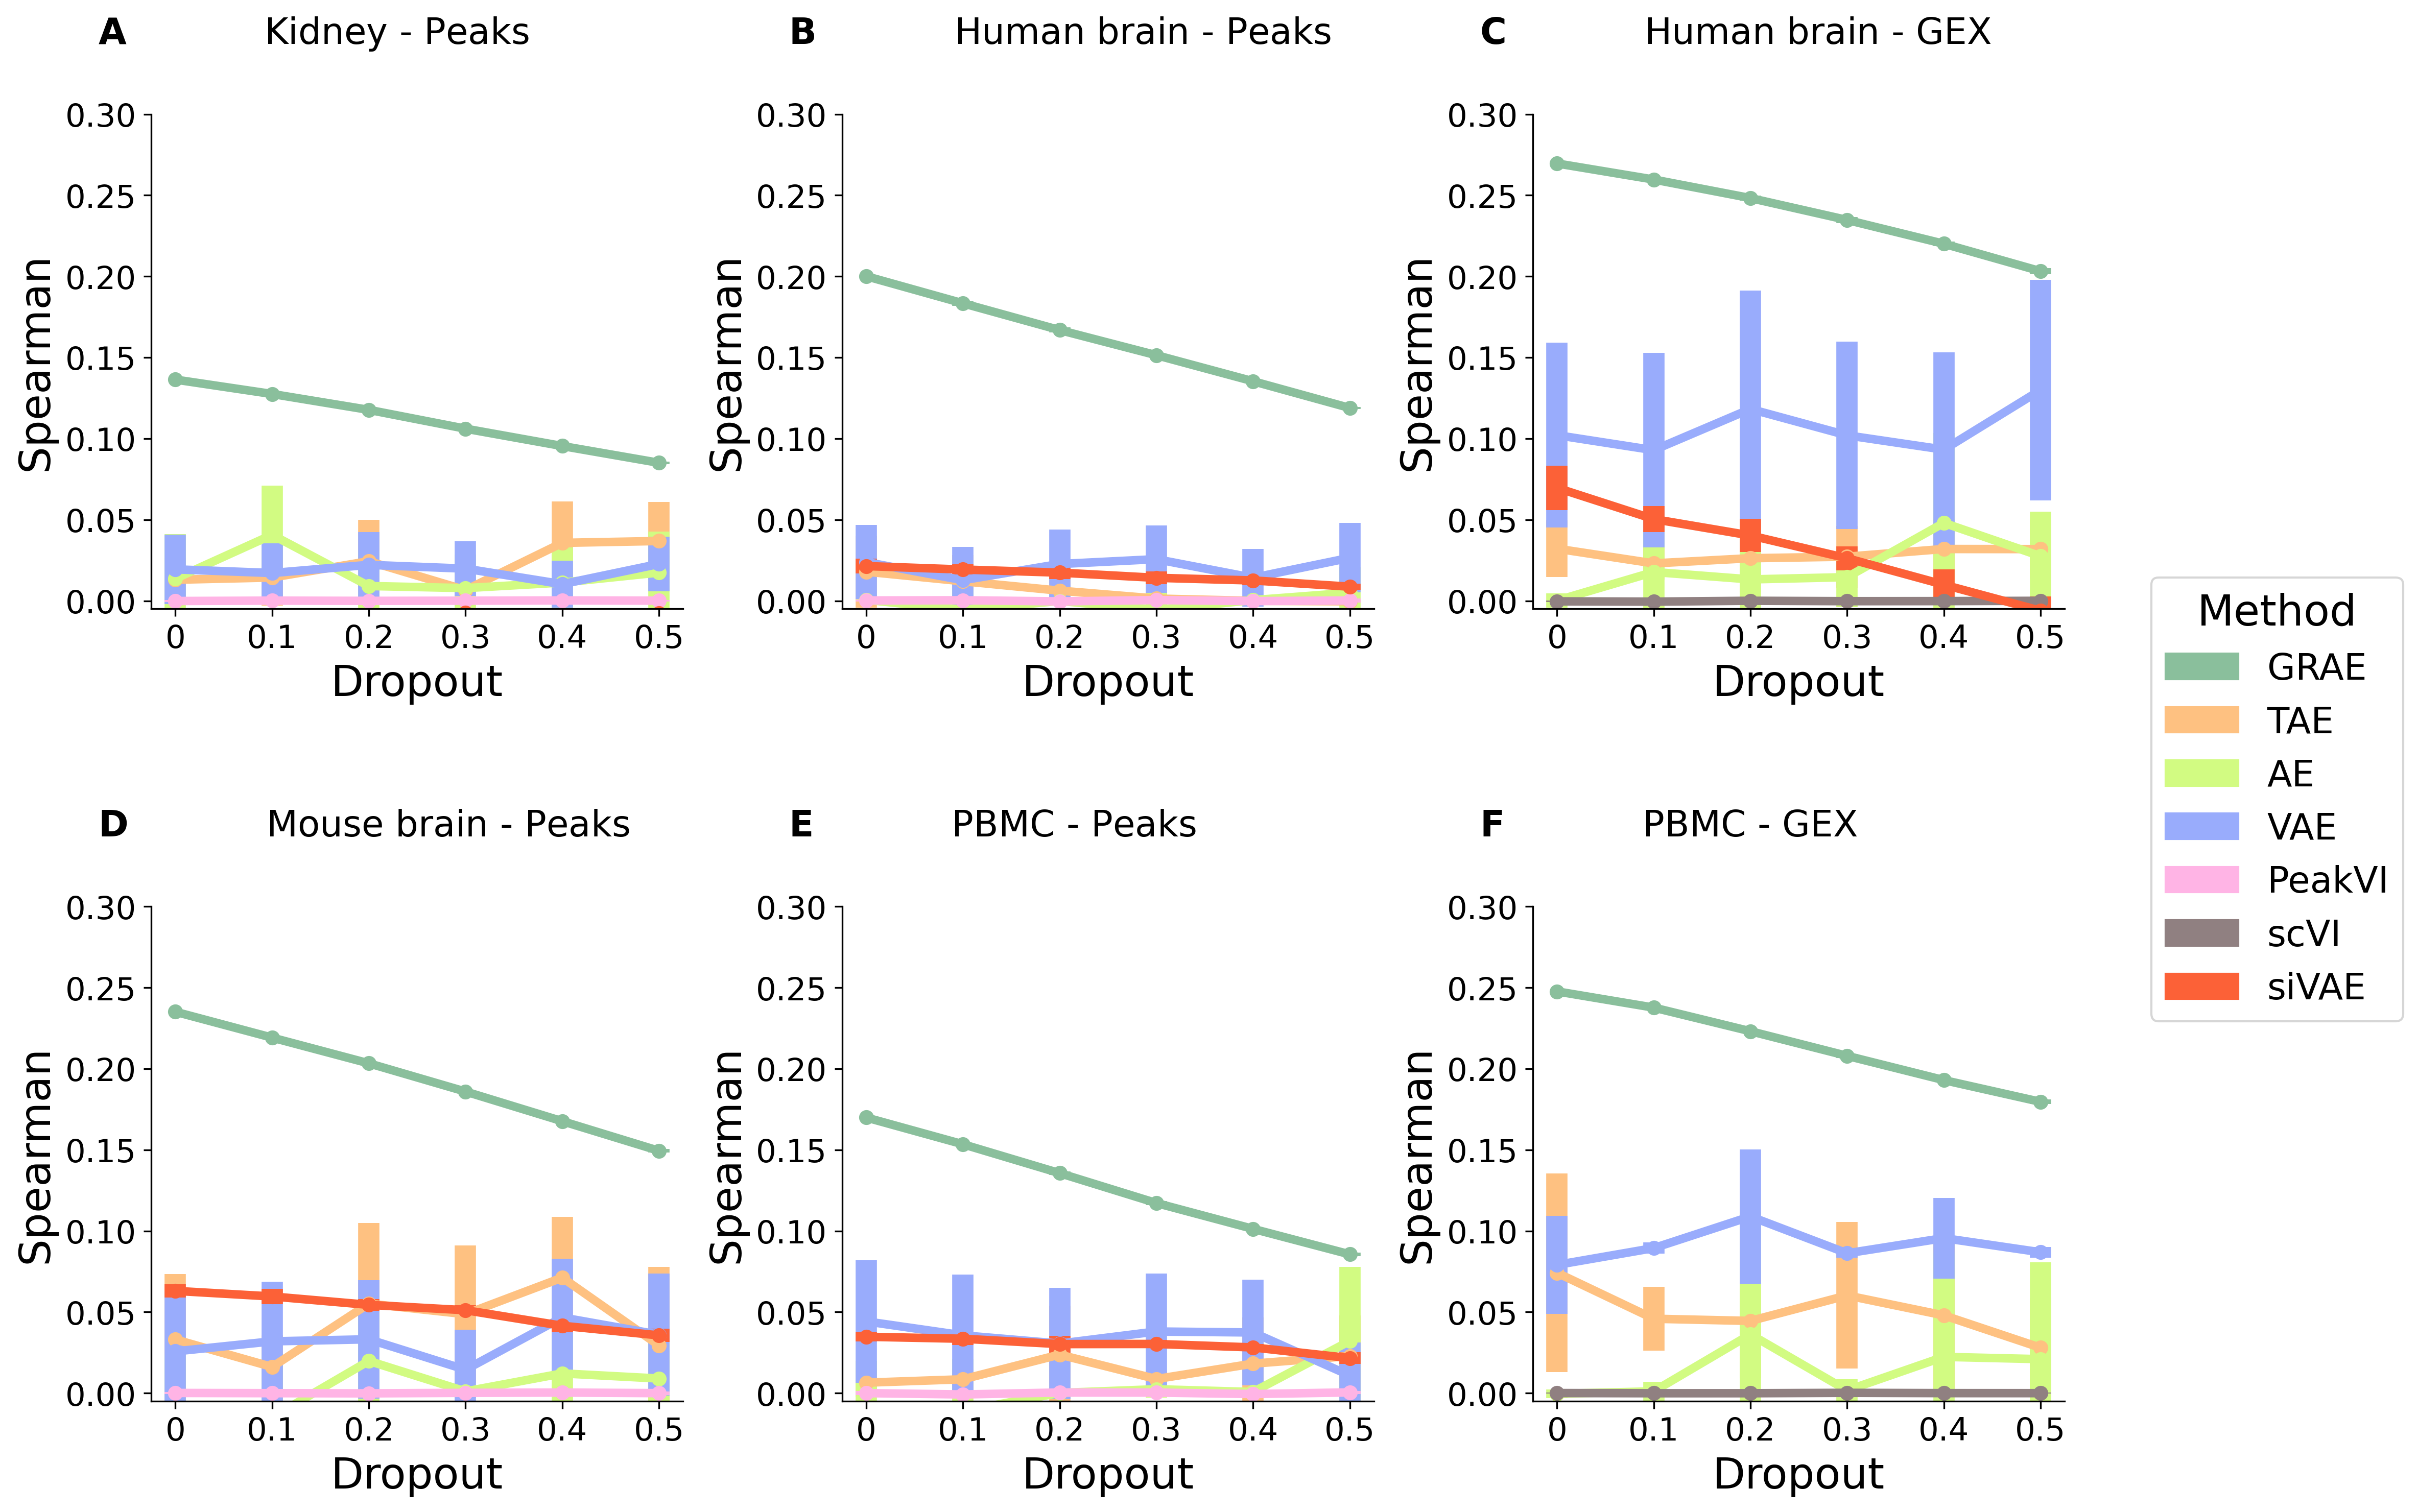

In [12]:
palette_red = {ae : palette[ae] for ae in palette.keys() if ae in set(df["AE"])}
x=np.linspace(0, 50, 6).astype(int)/100
xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5]
params = {'axes.labelsize': 20,
			'axes.titlesize': 20,
			'xtick.labelsize' : 15,
			'ytick.labelsize': 15,
			"lines.linewidth" : 4,
			"figure.dpi" : 300,
			"figure.figsize": [16, 10]}
plt.rcParams.update(params)
pad_pts=10
fig, axs = plt.subplots(2,3)
axs=axs.flatten()
i=0
for dataset, featurespace, job in zip(datasets, featurespaces, jobs):
    d=df[(df["Dataset"]==dataset) & (df["FS"]==featurespace)]
    for AE in AEs_order:
        if AE in list(set(d["AE"])):
                d_ae=d[d["AE"]==AE].copy()
                y=d_ae.groupby("Dropout")["Spearman"].mean()
                yerr=3*d_ae.groupby("Dropout")["Spearman"].sem()
                axs[i].errorbar(x=x, y=y, yerr=yerr, ecolor=palette_red[AE], elinewidth=10, marker="o", c=palette_red[AE])  
    letter=string.ascii_uppercase[i]
    axs[i].set_title(rf'$\mathbf{{{letter}}}$		{dataset} - {featurespace}', loc='left', size=17, pad=pad_pts, y=1.1, x=-0.1)
    i+=1
    
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(xticks, xticks)
    ax.set_ylim([-0.005, 0.3])
    ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
    ax.set_xlabel('Dropout', rotation=0)
    ax.set_ylabel('Spearman', rotation=90)
handles=[]
for key in AEs_order:
    if key in set(df["AE"]):
        handles.append(mpatches.Patch(color=palette_red[key], label=key))
axs[2].legend(bbox_to_anchor=(1.67, 0.1), title="Method", fontsize=17, title_fontsize=20, handles=handles)
fig.tight_layout(h_pad=-10)
plt.savefig(f"Figures/SEAGALL_SuppFig3.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

## SEAGALL_SuppFig4

In [13]:
df=pd.read_csv("Tables/Heteorgeneity.tsv.gz", sep="\t", index_col=0)
df2=pd.read_csv("Tables/Heteorgeneity_siVAE.tsv.gz", sep="\t", index_col=0)
df=pd.concat([df, df2])
df["Heteorgeneity"]=np.array(df["AbsoluteHetero"]/(df["NN"]*df["N_CT"]))
df["Homogeneity"]=1-df["Heteorgeneity"]
df["Method"]=df["Method"].str.replace("_kNN","")
print(df.shape)
df["FS"]=df["FS"].replace("Peak","Peaks")
df["Dataset"]=df["Dataset"].replace("10XhsBrain3kMO","Human brain")
df["Dataset"]=df["Dataset"].replace("10XhsPBMC10kMO","PBMC")
df["Dataset"]=df["Dataset"].replace("MouseBrain","Mouse brain")
df["Dataset"]=df["Dataset"].replace("Kidney","Kidney")
datasets=["Kidney","Human brain","Human brain", "Mouse brain", "PBMC","PBMC"]
featurespaces=["Peaks","Peaks", "GEX", "Peaks", "Peaks", "GEX"]
jobs=["BrP", "BrG", "KiP", "PbP", "PbG", "MbP"]
df.head()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
(8795670, 10)


Dataset     FS Method  AbsoluteHetero  NN  N_CT  Dropout  Run  \
0  Human brain  Peaks     AE               8  18     8      0.0  1.0   
1  Human brain  Peaks     AE               7  27     8      0.0  1.0   
2  Human brain  Peaks     AE               7  28     8      0.0  1.0   
3  Human brain  Peaks     AE               8  27     8      0.0  1.0   
4  Human brain  Peaks     AE               3  15     8      0.0  1.0   

   Heteorgeneity  Homogeneity  
0       0.055556     0.944444  
1       0.032407     0.967593  
2       0.031250     0.968750  
3       0.037037     0.962963  
4       0.025000     0.975000

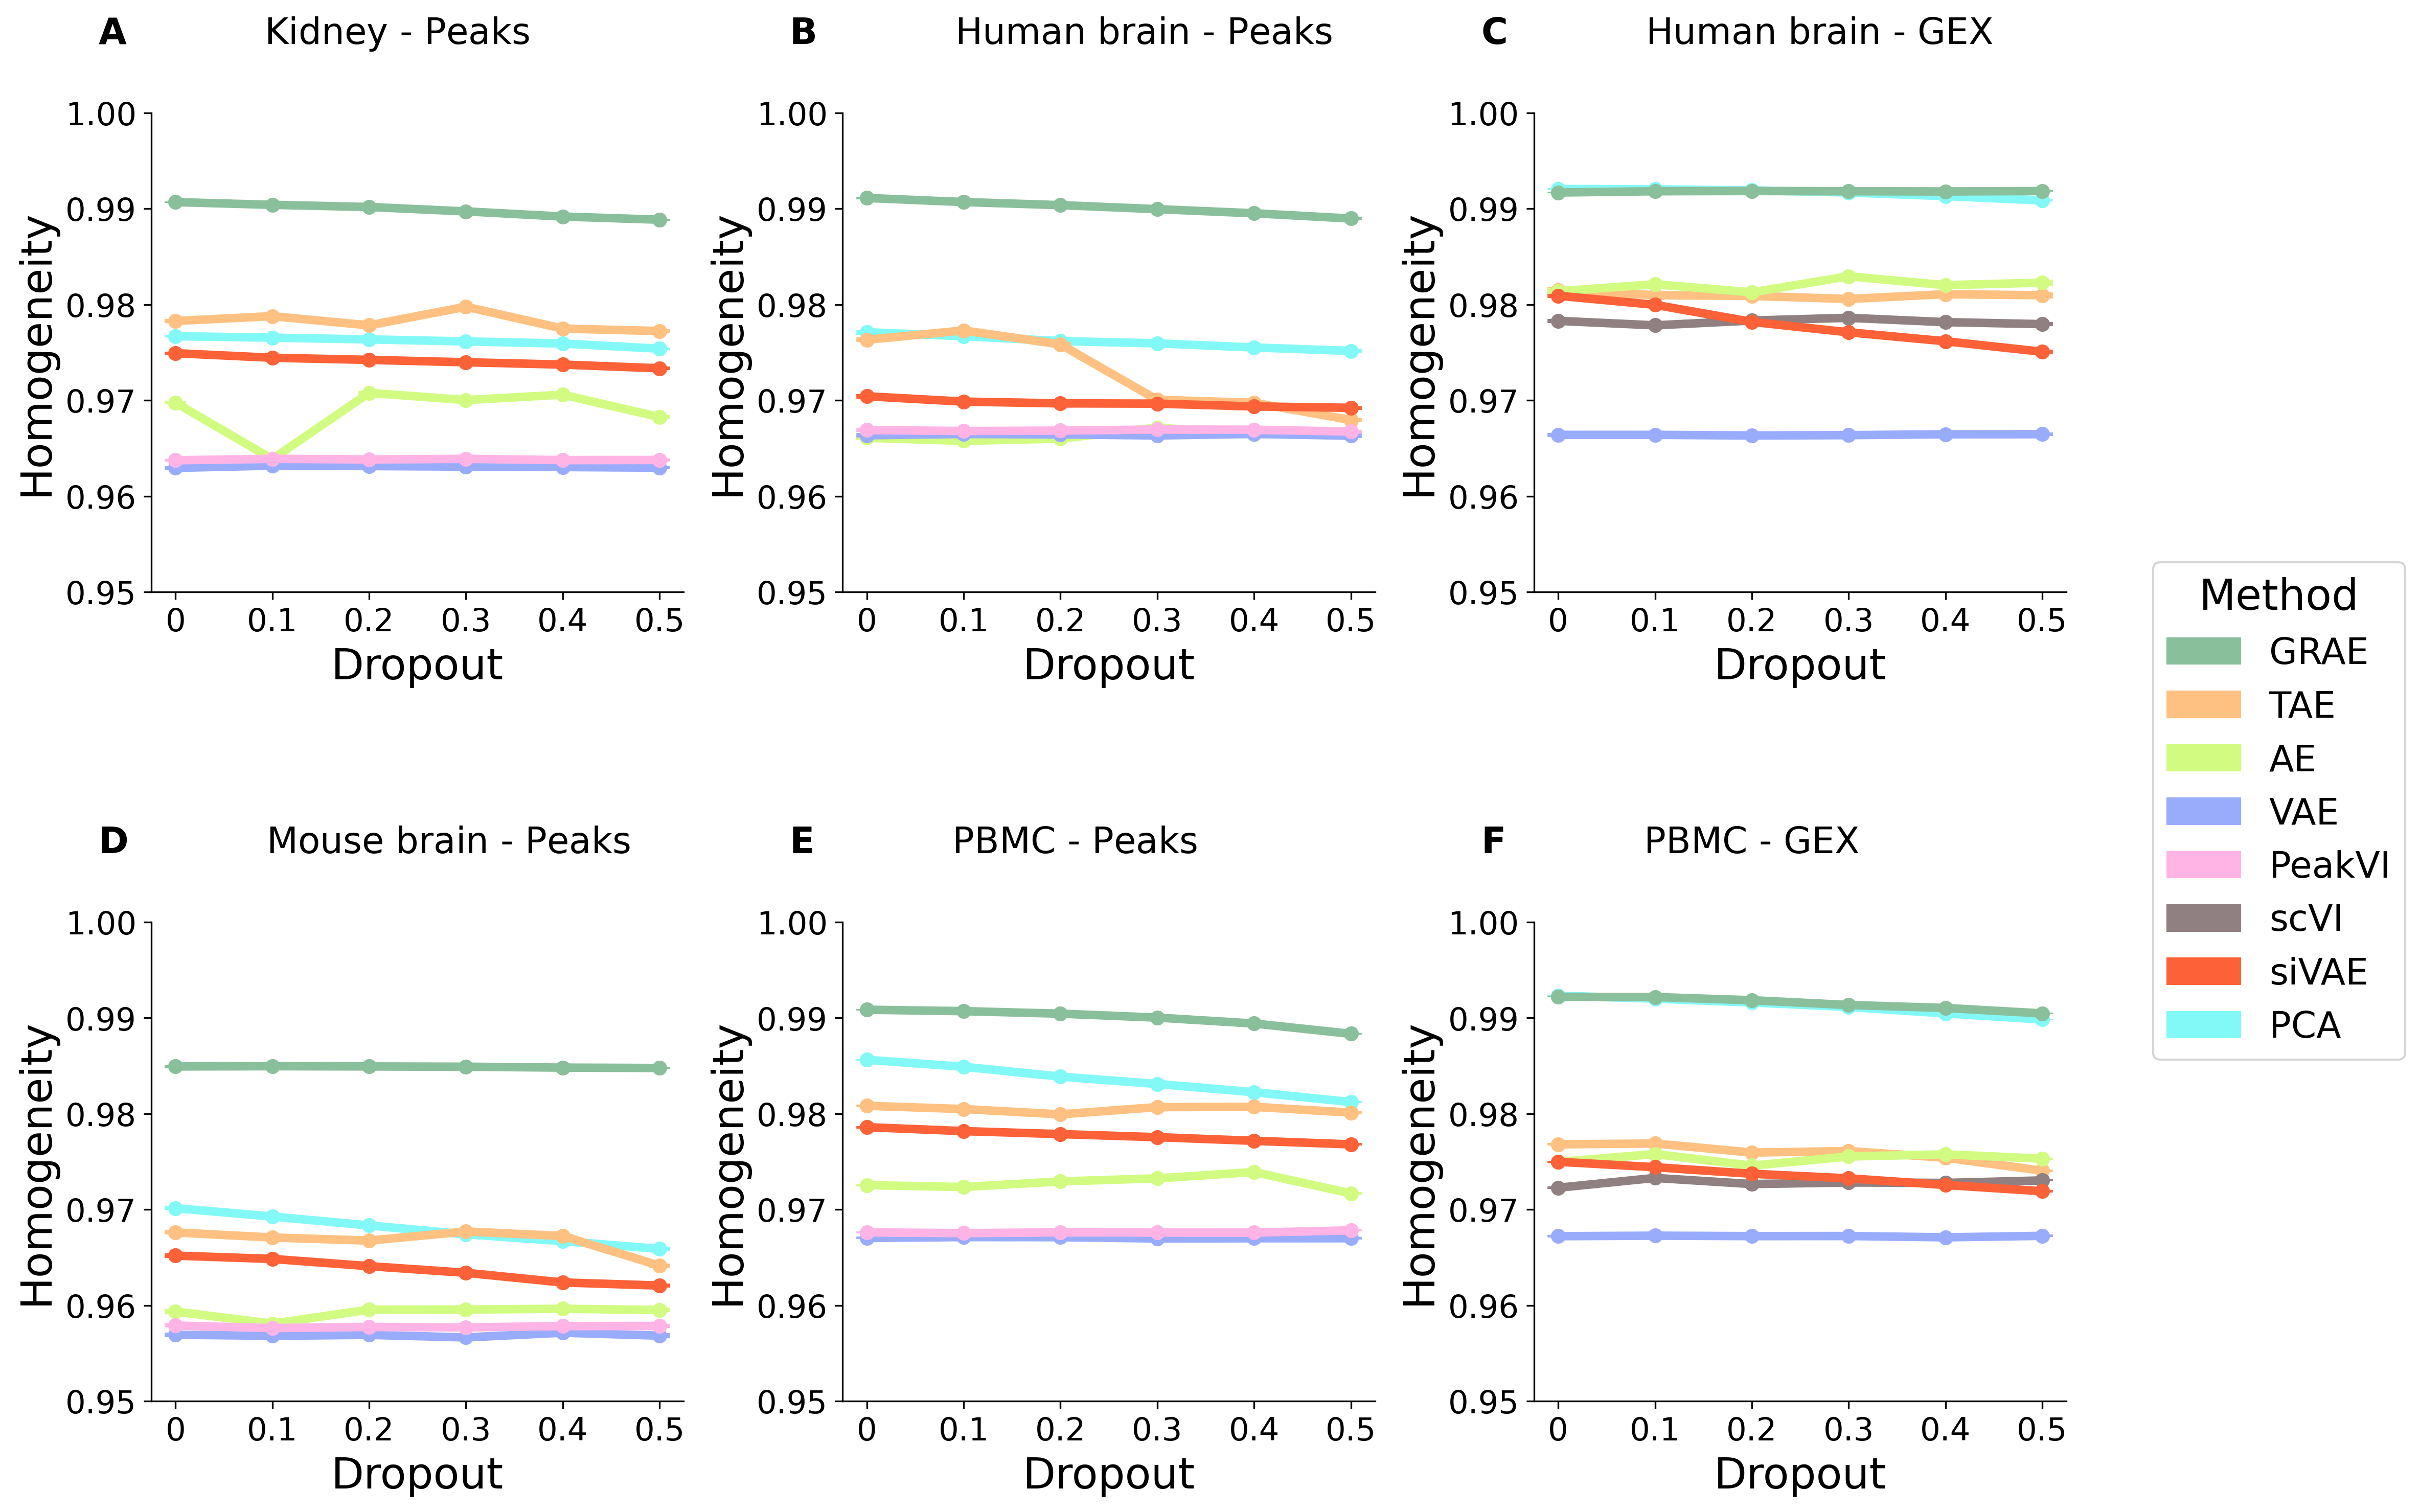

In [14]:
palette_red = {ae : palette[ae] for ae in palette.keys() if ae in set(df["Method"])}
x=np.linspace(0, 50, 6).astype(int)/100
xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5]
params = {'axes.labelsize': 20,
			'axes.titlesize': 20,
			'xtick.labelsize' : 15,
			'ytick.labelsize': 15,
			"lines.linewidth" : 4,
			"figure.dpi" : 300,
			"figure.figsize": [16, 10]}
plt.rcParams.update(params)
pad_pts=10
fig, axs = plt.subplots(2,3)
axs=axs.flatten()
i=0
for dataset, featurespace, job in zip(datasets, featurespaces, jobs):
    d=df[(df["Dataset"]==dataset) & (df["FS"]==featurespace)]
    for AE in AEs_order:
        if AE in list(set(d["Method"])):
                d_ae=d[d["Method"]==AE].copy()
                y=d_ae.groupby("Dropout")["Homogeneity"].mean()
                yerr=3*d_ae.groupby("Dropout")["Homogeneity"].sem()
                if AE == "PCA":
                    zorder=0
                else:
                    zorder=10
                axs[i].errorbar(x=x, y=y, yerr=yerr, ecolor=palette_red[AE], elinewidth=10, marker="o", c=palette_red[AE], zorder=zorder)  
    letter=string.ascii_uppercase[i]
    axs[i].set_title(rf'$\mathbf{{{letter}}}$		{dataset} - {featurespace}', loc='left', size=17, pad=pad_pts, y=1.1, x=-0.1)
    i+=1
    
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(xticks, xticks)
    ax.set_ylim([0.95, 1])
 #	ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
    ax.set_xlabel('Dropout', rotation=0)
    ax.set_ylabel('Homogeneity', rotation=90)
handles=[]
for key in AEs_order:
    if key in set(df["Method"]):
        handles.append(mpatches.Patch(color=palette_red[key], label=key))
axs[2].legend(bbox_to_anchor=(1.67, 0.1), title="Method", fontsize=17, title_fontsize=20, handles=handles)
fig.tight_layout(h_pad=-11)
plt.savefig(f"Figures/SEAGALL_SuppFig4.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

## SEAGALL_SuppFig1

In [15]:
df=pd.read_csv("Tables/Robustness.tsv.gz", sep="\t")
df2=pd.read_csv("Tables/Robustness_siVAE.tsv.gz", sep="\t")
df=pd.concat([df, df2])
df["AE"]=df["AE"].str.replace("_kNN","")
print(df.shape)
df["FS"]=df["FS"].replace("Peak","Peaks")
df["Dataset"]=df["Dataset"].replace("10XhsBrain3kMO","Human brain")
df["Dataset"]=df["Dataset"].replace("10XhsPBMC10kMO","PBMC")
df["Dataset"]=df["Dataset"].replace("MouseBrain","Mouse brain")
df["Dataset"]=df["Dataset"].replace("Kidney","Kidney")
datasets=["Kidney","Human brain","Human brain", "Mouse brain", "PBMC","PBMC"]
featurespaces=["Peaks","Peaks", "GEX", "Peaks", "Peaks", "GEX"]
jobs=["BrP", "BrG", "KiP", "PbP", "PbG", "MbP"]
df.head()

(1944, 10)


Dataset     FS      AE  Dropout       MSE   MSE1obs   MSE1imp  \
0  Human brain  Peaks      AE        0  0.011209  0.060707  0.011349   
1  Human brain  Peaks     VAE        0  0.247601  0.300532  0.257044   
2  Human brain  Peaks     TAE        0  0.009960  0.059894  0.007615   
3  Human brain  Peaks    GRAE        0  0.006533  0.035127  0.001869   
4  Human brain  Peaks  PeakVI        0  0.256767  0.245840  0.522231   

   Spearman    NBloss  Run  
0  0.001100  0.144949    1  
1  0.000247  0.304475    1  
2  0.012973  0.132526    1  
3  0.200109  0.042375    1  
4  0.000384  0.506129    1

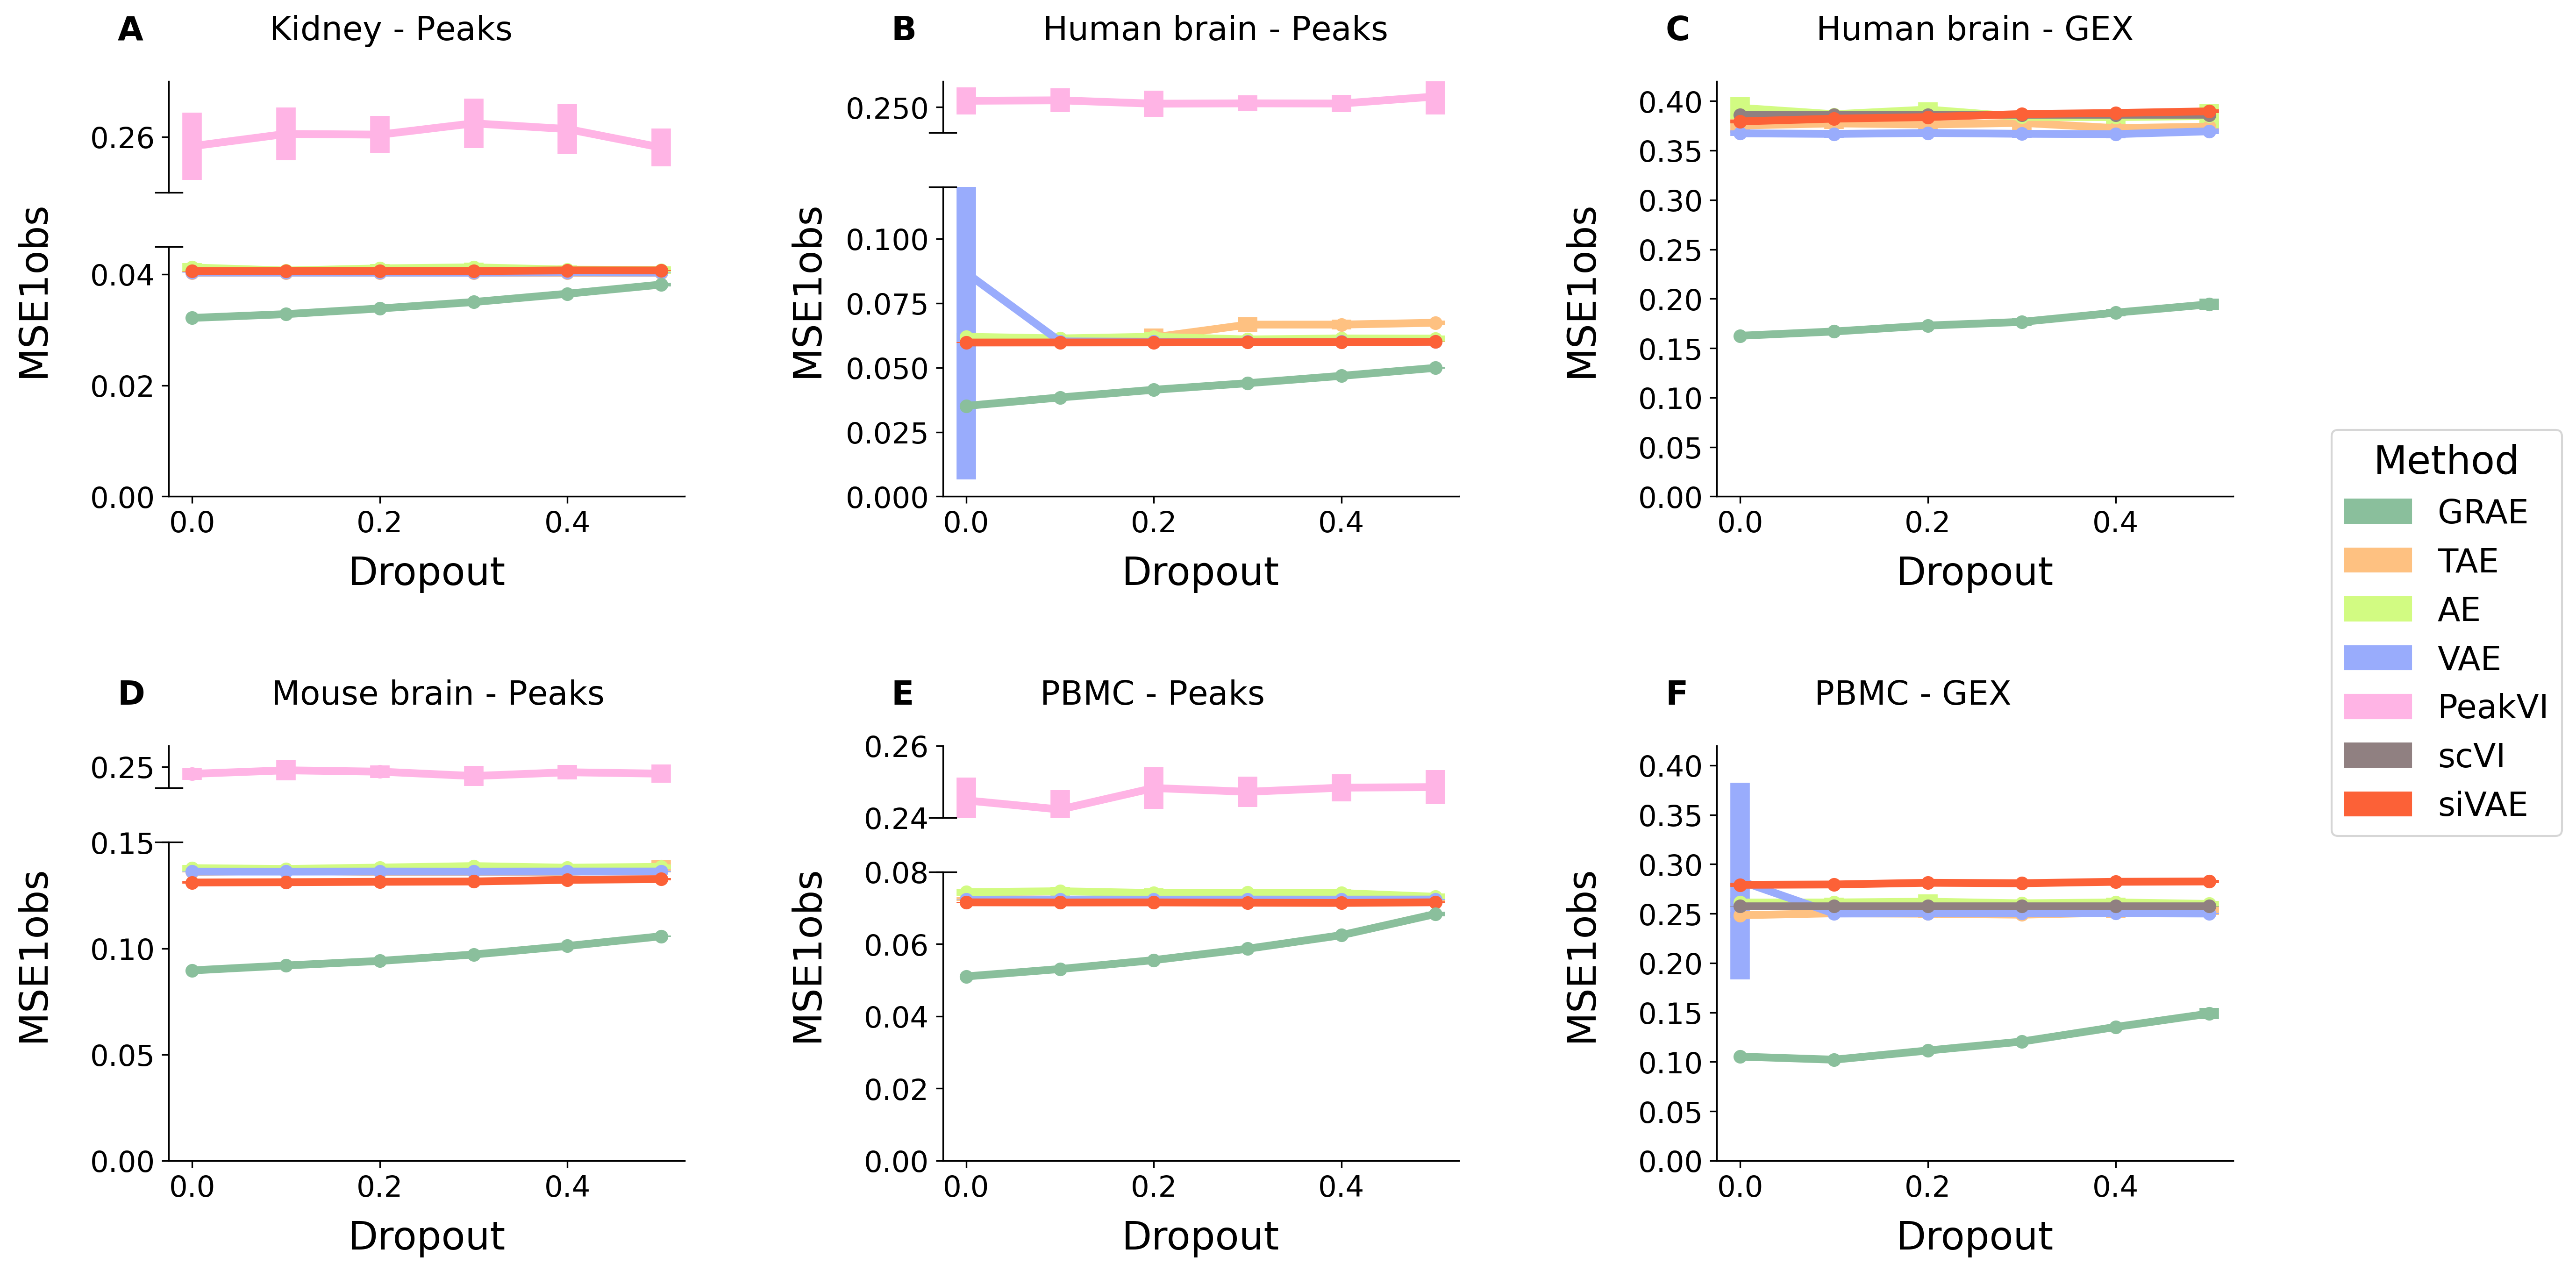

In [16]:
palette_red = {ae : palette[ae] for ae in palette.keys() if ae in set(df["AE"])}
x=np.linspace(0, 50, 6).astype(int)/100
xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5]
pad_pts=0
sps1, sps2 = GridSpec(2,1)
params = {'axes.labelsize': 20,
			'axes.titlesize': 20,
			'xtick.labelsize' : 15,
			'ytick.labelsize': 15,
			"lines.linewidth" : 4,
			"figure.dpi" : 300,
			"figure.figsize": [19, 10]}
plt.rcParams.update(params)
fig = plt.figure()

gs = GridSpec(2,3, wspace=0.5, hspace=0.6)
spss = {f"sps{i}" : sp for i, sp in enumerate(gs)}
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[0, 2])
ax6 = fig.add_subplot(gs[1, 2])
xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5]
i=0
for dataset, featurespace, job in zip(datasets, featurespaces, jobs):
    d=df[(df["Dataset"]==dataset) & (df["FS"]==featurespace)]
    if i == 0:
        maxy=0.045
        y_breaks=((0, maxy), (0.25,0.27))
    elif i == 1:
        maxy=0.12
        y_breaks=((0, maxy), (0.24,0.26))
    elif  i == 3:
        maxy=0.15
        y_breaks=((0, maxy), (0.24,0.26))
    elif i == 4:
        maxy=0.08
        y_breaks=((0, maxy), (0.24,0.26))
    else:
        y_breaks=None
    bax = brokax(ylims=y_breaks, hspace=0.3, subplot_spec=spss[f"sps{i}"], tilt=0, d=0.005)
    for AE in AEs_order:
        if AE in list(set(d["AE"])):
                zorder=10 if AE=="GRAE" else 1
                d_ae=d[d["AE"]==AE].copy()
                y=d_ae.groupby("Dropout")["MSE1obs"].mean()
                yerr=3*d_ae.groupby("Dropout")["MSE1obs"].sem()
                bax.errorbar(x=x, y=y, yerr=yerr, ecolor=palette_red[AE], elinewidth=10, marker="o", c=palette_red[AE], zorder=zorder)  
    bax.spines['top'][0].set_visible(False)
    bax.spines['right'][0].set_visible(False)
    try:
        bax.axs[0].set_xlabel('', rotation=0, labelpad=10)
        bax.axs[0].set_ylabel('', rotation=90, labelpad=10)
    except:
        bax.set_xlabel('', rotation=0, labelpad=10)
        bax.set_ylabel('', rotation=90, labelpad=10)
    letter=string.ascii_uppercase[i]
    bax.set_title(rf'$\mathbf{{{letter}}}$		{dataset} - {featurespace}', loc='left', size=17, pad=pad_pts, y=1.1, x=-0.1)
    if i == 2 or i == 5:
        bax.axs[0].set_ylim([0, 0.42])
    i+=1
    
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([], [])
    ax.set_xlabel('Dropout', rotation=0, labelpad=30)
    ax.set_ylabel('MSE1obs', rotation=90, labelpad=60)
handles=[]
for key in AEs_order:
    if key in set(df["AE"]):
        handles.append(mpatches.Patch(color=palette_red[key], label=key))
ax5.legend(bbox_to_anchor=(1.67, 0.2), title="Method", fontsize=17, title_fontsize=20, handles=handles)

plt.savefig(f"Figures/SEAGALL_SuppFig1_Up.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

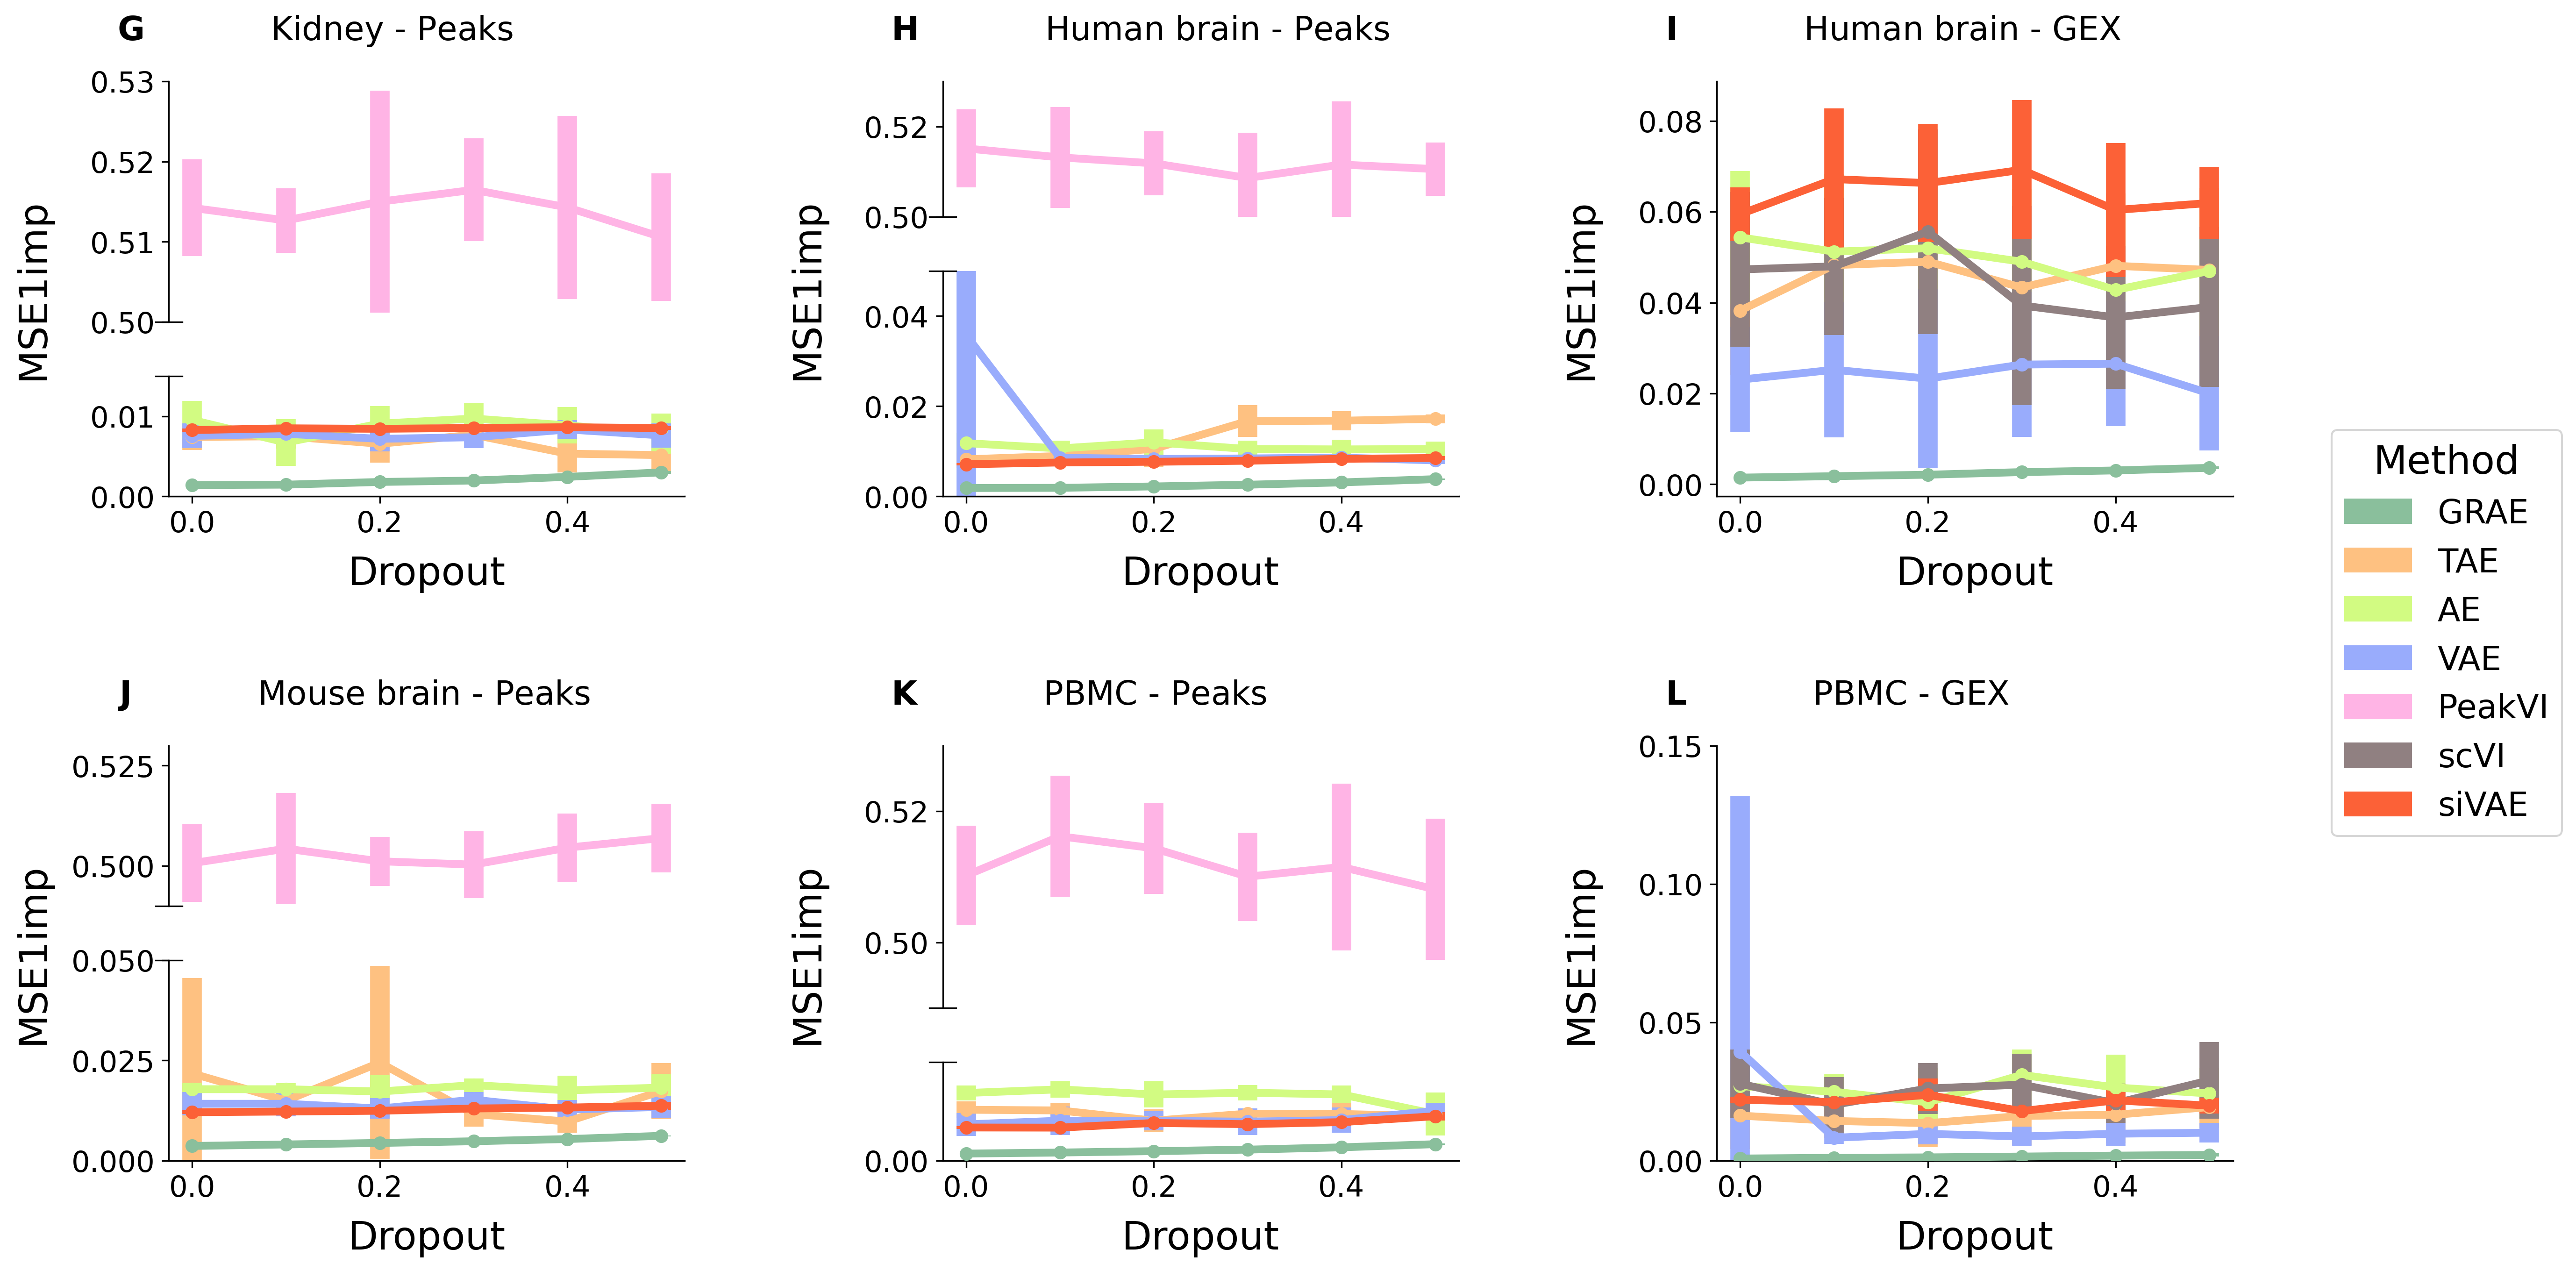

In [17]:
palette_red = {ae : palette[ae] for ae in palette.keys() if ae in set(df["AE"])}
x=np.linspace(0, 50, 6).astype(int)/100
xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5]
pad_pts=0
sps1, sps2 = GridSpec(2,1)
params = {'axes.labelsize': 20,
			'axes.titlesize': 20,
			'xtick.labelsize' : 15,
			'ytick.labelsize': 15,
			"lines.linewidth" : 4,
			"figure.dpi" : 300,
			"figure.figsize": [19, 10]}
plt.rcParams.update(params)
fig = plt.figure()

gs = GridSpec(2,3, wspace=0.5, hspace=0.6)
spss = {f"sps{i}" : sp for i, sp in enumerate(gs)}
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[0, 2])
ax6 = fig.add_subplot(gs[1, 2])
xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5]
i=0
for dataset, featurespace, job in zip(datasets, featurespaces, jobs):
    d=df[(df["Dataset"]==dataset) & (df["FS"]==featurespace)]
    if i == 0:
        maxy=0.015
        y_breaks=((0, maxy), (0.5,0.53))
    elif i == 1:
        maxy=0.05
        y_breaks=((0, maxy), (0.5,0.53))
    elif  i == 3:
        maxy=0.05
        y_breaks=((0, maxy), (0.49,0.53))
    elif i == 4:
        maxy=0.015
        y_breaks=((0, maxy), (0.49,0.53))
    else:
        y_breaks=None
    bax = brokax(ylims=y_breaks, hspace=0.3, subplot_spec=spss[f"sps{i}"], tilt=0, d=0.005)
    for AE in AEs_order:
        if AE in list(set(d["AE"])):
                zorder=10 if AE=="GRAE" else 1
                d_ae=d[d["AE"]==AE].copy()
                y=d_ae.groupby("Dropout")["MSE1imp"].mean()
                yerr=3*d_ae.groupby("Dropout")["MSE1imp"].sem()
                bax.errorbar(x=x, y=y, yerr=yerr, ecolor=palette_red[AE], elinewidth=10, marker="o", c=palette_red[AE], zorder=zorder)  
    bax.spines['top'][0].set_visible(False)
    bax.spines['right'][0].set_visible(False)
    try:
        bax.axs[0].set_xlabel('', rotation=0, labelpad=10)
        bax.axs[0].set_ylabel('', rotation=90, labelpad=10)
    except:
        bax.set_xlabel('', rotation=0, labelpad=10)
        bax.set_ylabel('', rotation=90, labelpad=10)
    letter=string.ascii_uppercase[i+6]
    bax.set_title(rf'$\mathbf{{{letter}}}$		{dataset} - {featurespace}', loc='left', size=17, pad=pad_pts, y=1.1, x=-0.1)
    if i == 5:
        bax.axs[0].set_ylim([0, 0.15])
    i+=1
    
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([], [])
    ax.set_xlabel('Dropout', rotation=0, labelpad=30)
    ax.set_ylabel('MSE1imp', rotation=90, labelpad=60)
handles=[]
for key in AEs_order:
    if key in set(df["AE"]):
        handles.append(mpatches.Patch(color=palette_red[key], label=key))
ax5.legend(bbox_to_anchor=(1.67, 0.2), title="Method", fontsize=17, title_fontsize=20, handles=handles)
plt.savefig(f"Figures/SEAGALL_SuppFig1_Down.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

## SEAGALL_SuppFig2

In [18]:
df=pd.read_csv("Tables/Robustness.tsv.gz", sep="\t")
df2=pd.read_csv("Tables/Robustness_siVAE.tsv.gz", sep="\t")
df=pd.concat([df, df2])
df["AE"]=df["AE"].str.replace("_kNN","")
print(df.shape)
df["FS"]=df["FS"].replace("Peak","Peaks")
df["Dataset"]=df["Dataset"].replace("10XhsBrain3kMO","Human brain")
df["Dataset"]=df["Dataset"].replace("10XhsPBMC10kMO","PBMC")
df["Dataset"]=df["Dataset"].replace("MouseBrain","Mouse brain")
df["Dataset"]=df["Dataset"].replace("Kidney","Kidney")
datasets=["Kidney","Human brain","Human brain", "Mouse brain", "PBMC","PBMC"]
featurespaces=["Peaks","Peaks", "GEX", "Peaks", "Peaks", "GEX"]
jobs=["BrP", "BrG", "KiP", "PbP", "PbG", "MbP"]
df.head()

(1944, 10)


Dataset     FS      AE  Dropout       MSE   MSE1obs   MSE1imp  \
0  Human brain  Peaks      AE        0  0.011209  0.060707  0.011349   
1  Human brain  Peaks     VAE        0  0.247601  0.300532  0.257044   
2  Human brain  Peaks     TAE        0  0.009960  0.059894  0.007615   
3  Human brain  Peaks    GRAE        0  0.006533  0.035127  0.001869   
4  Human brain  Peaks  PeakVI        0  0.256767  0.245840  0.522231   

   Spearman    NBloss  Run  
0  0.001100  0.144949    1  
1  0.000247  0.304475    1  
2  0.012973  0.132526    1  
3  0.200109  0.042375    1  
4  0.000384  0.506129    1

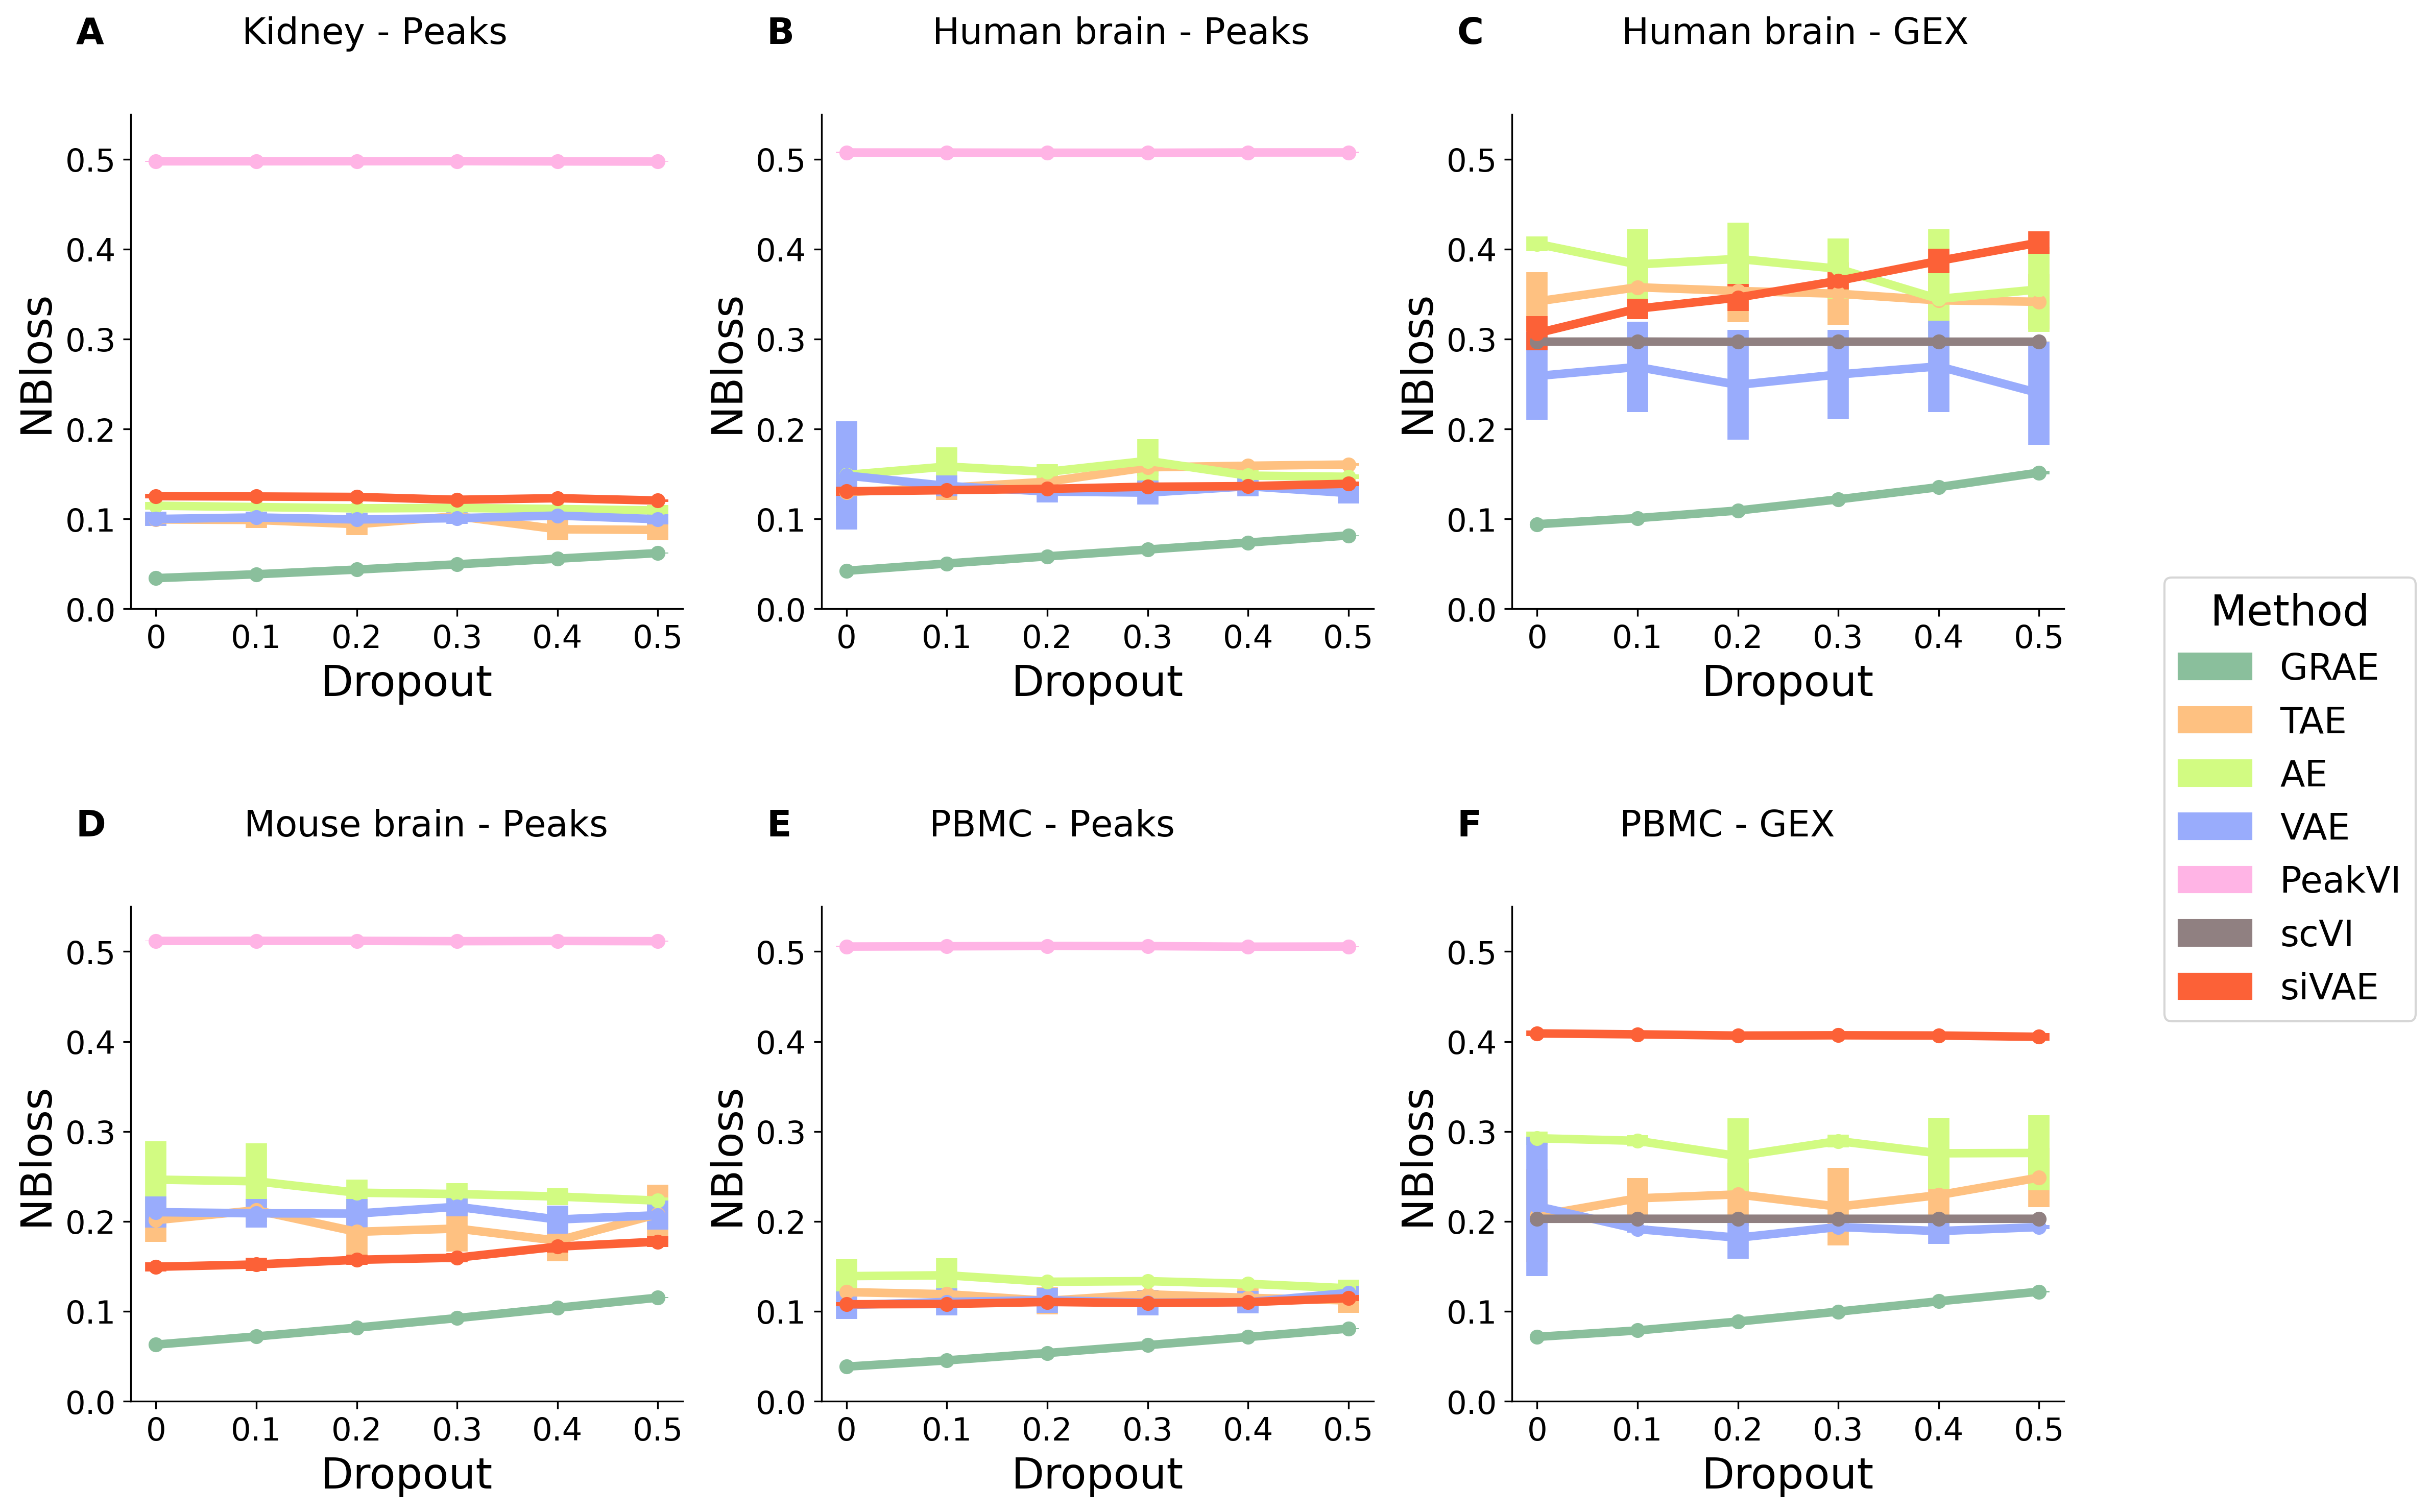

In [19]:
palette_red = {ae : palette[ae] for ae in palette.keys() if ae in set(df["AE"])}
x=np.linspace(0, 50, 6).astype(int)/100
xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5]
params = {'axes.labelsize': 20,
			'axes.titlesize': 20,
			'xtick.labelsize' : 15,
			'ytick.labelsize': 15,
			"lines.linewidth" : 4,
			"figure.dpi" : 300,
			"figure.figsize": [16, 10]}
plt.rcParams.update(params)
pad_pts=10
fig, axs = plt.subplots(2,3)
axs=axs.flatten()
i=0
for dataset, featurespace, job in zip(datasets, featurespaces, jobs):
    d=df[(df["Dataset"]==dataset) & (df["FS"]==featurespace)]
    for AE in AEs_order:
        if AE in list(set(d["AE"])):
                d_ae=d[d["AE"]==AE].copy()
                y=d_ae.groupby("Dropout")["NBloss"].mean()
                yerr=3*d_ae.groupby("Dropout")["NBloss"].sem()
                axs[i].errorbar(x=x, y=y, yerr=yerr, ecolor=palette_red[AE], elinewidth=10, marker="o", c=palette_red[AE])  
    letter=string.ascii_uppercase[i]
    axs[i].set_title(rf'$\mathbf{{{letter}}}$		{dataset} - {featurespace}', loc='left', size=17, pad=pad_pts, y=1.1, x=-0.1)
    i+=1
 
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(xticks, xticks)
    ax.set_ylim([0, 0.55])
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    ax.set_xlabel('Dropout', rotation=0)
    ax.set_ylabel('NBloss', rotation=90)
handles=[]
for key in AEs_order:
    if key in set(df["AE"]):
        handles.append(mpatches.Patch(color=palette_red[key], label=key))
axs[2].legend(bbox_to_anchor=(1.67, 0.1), title="Method", fontsize=17, title_fontsize=20, handles=handles)
fig.tight_layout(h_pad=-10)
plt.savefig(f"Figures/SEAGALL_SuppFig2.png", format="png", dpi=300, bbox_inches='tight')
plt.show()